## Training (Text_SSE)

In [ ]:
pip install torchnet

In [2]:
import json
import pickle
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchnet.dataset import TensorDataset
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef, confusion_matrix

In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/FML Project') 

## Set Device

In [4]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

GPU is available.


## Load Features and Labels

In [5]:
labels = np.load(sys.path[-1]+"/Data/labels.npy")
print('Labels loaded!')

Labels loaded!


In [6]:
text_features = torch.load(sys.path[-1]+"/Data/text_features_256.pt")
print('Text features loaded!')

Text features loaded!


## Split Data

In [7]:
df = pd.read_csv(sys.path[-1]+"/Data/df_final.csv")
train_ids = list(df[df['target_date'] < '2015-08-01'].index)
valid_ids = list(df[df['target_date'].between('2015-08-01','2015-10-01')].index)
test_ids = list(df[df['target_date'] > '2015-10-01'].index)
print(len(train_ids), len(valid_ids), len(test_ids))

14040 1910 2593


In [8]:
dataset = TensorDataset([text_features.float(), torch.tensor(labels).float()])

train_set = TensorDataset([torch.utils.data.Subset(dataset, train_ids)])
valid_set = TensorDataset([torch.utils.data.Subset(dataset, valid_ids)])
test_set = TensorDataset([torch.utils.data.Subset(dataset, test_ids)])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

print('Datasets ready!')

Datasets ready!


## Evaluation Metrics

In [9]:
def compute_accuracy(y_true, y_pred):
    assert (len(y_true) == len(y_pred))
    return accuracy_score(np.array(y_true), np.array(y_pred))

def compute_f1(y_true, y_pred):
    assert (len(y_true) == len(y_pred))
    return f1_score(np.array(y_true), np.array(y_pred))

def compute_MCC(y_true, y_pred):
    assert (len(y_true) == len(y_pred))
    return matthews_corrcoef(np.array(y_true), np.array(y_pred))

def evaluate_metrics(preds, labels):
    labels = [int(item) for item in labels]
    preds = [0 if item < 0.5 else 1 for item in preds]
    accuracy = compute_accuracy(labels, preds)
    f1 = compute_f1(labels, preds)
    mcc = compute_MCC(labels, preds)
    cm = confusion_matrix(labels, preds)
    return accuracy, f1, mcc, cm

## Training

In [10]:
def save_model(model, name):
    torch.save(model.state_dict(), name)

def load_model(model, name):
    weights = torch.load(name)
    model.load_state_dict(weights)
    return model

In [11]:
def train_model(model, params, train_loader, valid_loader, test_loader, report_loss=True):

    device = params['device']
    n_epochs = params['n_epochs']
    criterion = params['criterion']
    optimizer = params['optimizer']
    scheduler = params['scheduler']

    stop = 0
    best_valid_mcc = -1

    valid_metrics = {}
    test_metrics = {}
    train_loss, valid_loss, test_loss = [], [], []
    valid_a, valid_f1, valid_mcc, valid_cm = [], [], [], []
    test_a, test_f1, test_mcc, test_cm = [], [], [], []

    f = nn.Sigmoid()

    for epoch in range(n_epochs):

        train_loss_i, batch, total = 0.0, 0, 0
        model.train()
        for data in tqdm(train_loader):
            if params['model_type'] == 'unimodal':
                x, labels = data[0][0].to(device), data[0][1].to(device)
                preds = model(x)
            elif params['model_type'] == 'bimodal':
                x_txt, x_img, labels = data[0][0].to(device), data[0][1].to(device), data[0][2].to(device)
                preds = model(x_txt, x_img)
            preds = f(preds).squeeze()
            loss = criterion(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_i += loss.item()
            batch += 1
            total += labels.shape[0]
            if report_loss and batch%200==0:
                print("Batch: {}, Training Loss: {:.4f}".format(batch, train_loss_i/total))
        train_loss_i = train_loss_i / len(train_loader.dataset)

        valid_loss_i = 0.0
        valid_preds, valid_labels= [], []
        model.eval()
        with torch.no_grad():
            for data in tqdm(valid_loader):
                if params['model_type'] == 'unimodal':
                    x, labels = data[0][0].to(device), data[0][1].to(device)
                    preds = model(x)
                elif params['model_type'] == 'bimodal':
                    x_txt, x_img, labels = data[0][0].to(device), data[0][1].to(device), data[0][2].to(device)
                    preds = model(x_txt, x_img)
                preds = f(preds).squeeze()
                loss = criterion(preds, labels)
                valid_loss_i += loss.item()
                valid_preds.append(preds)
                valid_labels.append(labels)
        valid_loss_i = valid_loss_i / len(valid_loader.dataset)
        valid_preds = torch.cat(valid_preds)
        valid_labels = torch.cat(valid_labels)

        valid_a_i, valid_f1_i, valid_mcc_i, valid_cm_i = evaluate_metrics(valid_preds, valid_labels)

        test_loss_i = 0.0
        test_preds, test_labels= [], []
        model.eval()
        with torch.no_grad():
            for data in tqdm(test_loader):
                if params['model_type'] == 'unimodal':
                    x, labels = data[0][0].to(device), data[0][1].to(device)
                    preds = model(x)
                elif params['model_type'] == 'bimodal':
                    x_txt, x_img, labels = data[0][0].to(device), data[0][1].to(device), data[0][2].to(device)
                    preds = model(x_txt, x_img)
                preds = f(preds).squeeze()
                loss = criterion(preds, labels)
                test_loss_i += loss.item()
                test_preds.append(preds)
                test_labels.append(labels)
        test_loss_i = test_loss_i / len(test_loader.dataset)
        test_preds = torch.cat(test_preds)
        test_labels = torch.cat(test_labels)

        test_a_i, test_f1_i, test_mcc_i, test_cm_i = evaluate_metrics(test_preds, test_labels)

        scheduler.step(valid_loss_i)  # decay learning rate by validation loss

        if valid_mcc_i > best_valid_mcc:
            save_model(model, sys.path[-1]+'/Models/'+params['model_name']+'.pt')
            print("Saved model at epoch {} with validation MCC score of {:.4f}%".format(epoch+1, valid_mcc_i))
            best_valid_mcc = valid_mcc_i

        if report_loss:
            print("\n")
            print("-" * 50)
            print("Epoch ", epoch+1)
            print("Training Loss: {:.4f}, Validation Loss: {:.4f}".format(train_loss_i, valid_loss_i))
            print('Validation Results: ')
            print("Accuracy: {:.4f}".format(valid_a_i))
            print("F1 Score: {:.4f}".format(valid_f1_i))
            print("MCC Score: {:.4f}".format(valid_mcc_i))
            print('Test Results: ')
            print("Accuracy: {:.4f}".format(test_a_i))
            print("F1 Score: {:.4f}".format(test_f1_i))
            print("MCC Score: {:.4f}".format(test_mcc_i))
            print("-" * 50)
            print("\n")
        
        train_loss.append(train_loss_i)
        valid_loss.append(valid_loss_i)
        test_loss.append(test_loss_i)

        valid_a.append(valid_a_i)
        valid_f1.append(valid_f1_i)
        valid_mcc.append(valid_mcc_i)
        valid_cm.append(valid_cm_i)

        test_a.append(test_a_i)
        test_f1.append(test_f1_i)
        test_mcc.append(test_mcc_i)
        test_cm.append(test_cm_i)


        if len(valid_loss) > 0:  
            if valid_loss_i <= valid_loss[-1]:
                stop = 0
            else:
                stop += 1
                if stop >= int(params['n_stop']):   # stop training when no improvement observed in consecutive epoches
                    print("Early stopped. No improvement in validation loss for params['n_stop'] consecutive epoches.")
                    break

    valid_metrics['acc'] = valid_a
    valid_metrics['f1'] = valid_f1
    valid_metrics['mcc'] = valid_mcc
    valid_metrics['cm'] = valid_cm

    test_metrics['acc'] = test_a
    test_metrics['f1'] = test_f1
    test_metrics['mcc'] = test_mcc
    test_metrics['cm'] = test_cm

    return train_loss, valid_loss, test_loss, valid_metrics, test_metrics

## Models

In [12]:
class Text_SSE(nn.Module):
    """
    Unimodal (text) classifier based on self-supervised embeddings.
    """
    def __init__(self, params):
        super(Text_SSE, self).__init__()
        # functional layers
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=params['txt_dropout'])
        # fully connected layers
        self.reduce_dim = nn.Linear(in_features=params['txt_embed_size'],
                                    out_features=params['hidden_size'])
        self.classifier = nn.Linear(in_features=params['hidden_size'],
                                    out_features=1)

    def forward(self, x_txt):
        """
        Input:
            x_txt   | text self-supervised embeddings, shape = (batch_size, txt_embedding_size)
        Output:
            y       | unnormalized logits, shape = (batch_size, 1)
        """
        # dimension reduction
        x_txt = self.relu(self.reduce_dim(x_txt))
        # dropout
        x_txt = self.dropout(x_txt)
        # temporal average as global representation
        x_txt = torch.mean(x_txt, dim=1)
        # classification
        y = self.classifier(x_txt)
        return y

## Unimodal

In [13]:
model_params = {'txt_embed_size': 768,
                'img_embed_size': 2048,
                'hidden_size': 512,
                'txt_H': 4,
                'vt_H': 4,
                'txt_dropout': 0.01,
                'img_dropout': 0.01,
                'vt_dropout': 0.01,
                'transformer_dropout': 0.01}  

best_acc, best_f1, best_mcc, best_cm = [], [], [], []

for i in range(5):

    model = Text_SSE(model_params)
    model.to(device)
    criterion = nn.BCELoss()    
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)
    train_params = {'n_epochs': 30,
                    'criterion': criterion,
                    'optimizer': optimizer,
                    'scheduler': scheduler,
                    'n_stop': 8,
                    'model_name': 'Text_SSE',
                    'model_type': 'unimodal',
                    'device': device}

    train_loss, valid_loss, test_loss, valid_metrics, test_metrics = train_model(model, train_params, train_loader, valid_loader, test_loader)
        
    idx = np.argmax(test_metrics['mcc'])
    best_acc.append(test_metrics['acc'][idx])
    best_f1.append(test_metrics['f1'][idx])
    best_mcc.append(test_metrics['mcc'][idx])
    best_cm.append(test_metrics['cm'][idx])

    with open(sys.path[-1]+f"/Training Results/train_loss_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(train_loss, f)
    with open(sys.path[-1]+f"/Training Results/valid_loss_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(valid_loss, f)
    with open(sys.path[-1]+f"/Training Results/test_loss_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(test_loss, f)
    with open(sys.path[-1]+f"/Training Results/valid_metrics_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(valid_metrics, f)
    with open(sys.path[-1]+f"/Training Results/test_metrics_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(test_metrics, f)

 26%|██▋       | 232/878 [00:04<00:04, 160.97it/s]

Batch: 200, Training Loss: 0.0435


 49%|████▉     | 431/878 [00:05<00:02, 176.93it/s]

Batch: 400, Training Loss: 0.0435


 72%|███████▏  | 629/878 [00:06<00:01, 168.76it/s]

Batch: 600, Training Loss: 0.0435


 94%|█████████▎| 822/878 [00:07<00:00, 166.88it/s]

Batch: 800, Training Loss: 0.0434


100%|██████████| 21/21 [00:00<00:00, 22.72it/s]


Saved model at epoch 1 with validation MCC score of -0.0275%


--------------------------------------------------
Epoch  1
Training Loss: 0.0435, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5105
F1 Score: 0.3110
MCC Score: -0.0275
Test Results: 
Accuracy: 0.4855
F1 Score: 0.3898
MCC Score: -0.0116
--------------------------------------------------




 26%|██▌       | 226/878 [00:01<00:03, 167.02it/s]

Batch: 200, Training Loss: 0.0432


 49%|████▉     | 434/878 [00:02<00:02, 167.71it/s]

Batch: 400, Training Loss: 0.0432


 71%|███████▏  | 626/878 [00:03<00:01, 170.95it/s]

Batch: 600, Training Loss: 0.0432


 94%|█████████▍| 824/878 [00:04<00:00, 174.08it/s]

Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 22.66it/s]


Saved model at epoch 2 with validation MCC score of -0.0038%


--------------------------------------------------
Epoch  2
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4565
F1 Score: 0.6167
MCC Score: -0.0038
Test Results: 
Accuracy: 0.5245
F1 Score: 0.6838
MCC Score: 0.0047
--------------------------------------------------




 25%|██▌       | 223/878 [00:01<00:03, 173.60it/s]

Batch: 200, Training Loss: 0.0431


 48%|████▊     | 420/878 [00:02<00:02, 170.47it/s]

Batch: 400, Training Loss: 0.0431


 72%|███████▏  | 632/878 [00:03<00:01, 175.73it/s]

Batch: 600, Training Loss: 0.0432


 95%|█████████▍| 831/878 [00:04<00:00, 178.41it/s]

Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 22.31it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4906
F1 Score: 0.4726
MCC Score: -0.0167
Test Results: 
Accuracy: 0.5017
F1 Score: 0.5392
MCC Score: -0.0022
--------------------------------------------------




 26%|██▌       | 225/878 [00:01<00:03, 166.27it/s]

Batch: 200, Training Loss: 0.0430


 49%|████▉     | 434/878 [00:02<00:02, 170.92it/s]

Batch: 400, Training Loss: 0.0430


 72%|███████▏  | 633/878 [00:03<00:01, 172.99it/s]

Batch: 600, Training Loss: 0.0430


 95%|█████████▍| 833/878 [00:04<00:00, 179.88it/s]

Batch: 800, Training Loss: 0.0430


100%|██████████| 21/21 [00:00<00:00, 22.05it/s]




--------------------------------------------------
Epoch  4
Training Loss: 0.0431, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5016
F1 Score: 0.3434
MCC Score: -0.0357
Test Results: 
Accuracy: 0.4844
F1 Score: 0.3909
MCC Score: -0.0145
--------------------------------------------------




 26%|██▌       | 230/878 [00:01<00:03, 172.24it/s]

Batch: 200, Training Loss: 0.0429


 48%|████▊     | 424/878 [00:02<00:02, 165.84it/s]

Batch: 400, Training Loss: 0.0429


 71%|███████   | 622/878 [00:03<00:01, 171.46it/s]

Batch: 600, Training Loss: 0.0429


 94%|█████████▎| 821/878 [00:04<00:00, 173.59it/s]

Batch: 800, Training Loss: 0.0429


100%|██████████| 21/21 [00:00<00:00, 21.75it/s]


Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.


--------------------------------------------------
Epoch  5
Training Loss: 0.0429, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4524
F1 Score: 0.5971
MCC Score: -0.0353
Test Results: 
Accuracy: 0.5307
F1 Score: 0.6726
MCC Score: 0.0359
--------------------------------------------------




 26%|██▌       | 226/878 [00:01<00:03, 174.06it/s]

Batch: 200, Training Loss: 0.0427


 48%|████▊     | 424/878 [00:02<00:02, 173.00it/s]

Batch: 400, Training Loss: 0.0426


 71%|███████   | 625/878 [00:03<00:01, 179.82it/s]

Batch: 600, Training Loss: 0.0426


 94%|█████████▍| 825/878 [00:04<00:00, 176.65it/s]

Batch: 800, Training Loss: 0.0426


100%|██████████| 21/21 [00:00<00:00, 22.78it/s]




--------------------------------------------------
Epoch  6
Training Loss: 0.0426, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4916
F1 Score: 0.4816
MCC Score: -0.0119
Test Results: 
Accuracy: 0.4944
F1 Score: 0.5333
MCC Score: -0.0171
--------------------------------------------------




 27%|██▋       | 234/878 [00:01<00:03, 187.34it/s]

Batch: 200, Training Loss: 0.0426


 49%|████▉     | 432/878 [00:02<00:02, 183.62it/s]

Batch: 400, Training Loss: 0.0426


 71%|███████   | 624/878 [00:03<00:01, 185.95it/s]

Batch: 600, Training Loss: 0.0425


 94%|█████████▎| 821/878 [00:04<00:00, 187.71it/s]

Batch: 800, Training Loss: 0.0425


100%|██████████| 21/21 [00:00<00:00, 22.34it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0425, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4848
F1 Score: 0.5143
MCC Score: -0.0110
Test Results: 
Accuracy: 0.4960
F1 Score: 0.5616
MCC Score: -0.0212
--------------------------------------------------




 26%|██▋       | 231/878 [00:01<00:03, 193.09it/s]

Batch: 200, Training Loss: 0.0424


 49%|████▉     | 432/878 [00:02<00:02, 189.50it/s]

Batch: 400, Training Loss: 0.0424


 71%|███████   | 625/878 [00:03<00:01, 186.67it/s]

Batch: 600, Training Loss: 0.0425


 94%|█████████▍| 825/878 [00:04<00:00, 190.09it/s]

Batch: 800, Training Loss: 0.0424


100%|██████████| 21/21 [00:00<00:00, 22.79it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0425, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4853
F1 Score: 0.5102
MCC Score: -0.0117
Test Results: 
Accuracy: 0.4979
F1 Score: 0.5586
MCC Score: -0.0159
--------------------------------------------------




 27%|██▋       | 234/878 [00:01<00:03, 171.36it/s]

Batch: 200, Training Loss: 0.0423


 49%|████▉     | 430/878 [00:02<00:02, 167.94it/s]

Batch: 400, Training Loss: 0.0423


 72%|███████▏  | 628/878 [00:03<00:01, 173.79it/s]

Batch: 600, Training Loss: 0.0424


 93%|█████████▎| 817/878 [00:04<00:00, 164.17it/s]

Batch: 800, Training Loss: 0.0424


100%|██████████| 21/21 [00:00<00:00, 21.94it/s]


Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.
Saved model at epoch 9 with validation MCC score of 0.0009%


--------------------------------------------------
Epoch  9
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4984
F1 Score: 0.4861
MCC Score: 0.0009
Test Results: 
Accuracy: 0.4998
F1 Score: 0.5366
MCC Score: -0.0059
--------------------------------------------------




 27%|██▋       | 233/878 [00:01<00:03, 174.38it/s]

Batch: 200, Training Loss: 0.0424


 49%|████▉     | 431/878 [00:02<00:02, 172.27it/s]

Batch: 400, Training Loss: 0.0423


 72%|███████▏  | 632/878 [00:03<00:01, 179.40it/s]

Batch: 600, Training Loss: 0.0423


 95%|█████████▍| 832/878 [00:04<00:00, 171.77it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.42it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4974
F1 Score: 0.4844
MCC Score: -0.0014
Test Results: 
Accuracy: 0.4994
F1 Score: 0.5354
MCC Score: -0.0064
--------------------------------------------------




 26%|██▌       | 227/878 [00:01<00:03, 168.67it/s]

Batch: 200, Training Loss: 0.0423


 48%|████▊     | 420/878 [00:02<00:02, 174.44it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████▏  | 627/878 [00:03<00:01, 163.07it/s]

Batch: 600, Training Loss: 0.0423


 95%|█████████▍| 831/878 [00:05<00:00, 164.88it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.25it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.4858
MCC Score: -0.0148
Test Results: 
Accuracy: 0.5006
F1 Score: 0.5435
MCC Score: -0.0058
--------------------------------------------------




 27%|██▋       | 234/878 [00:01<00:03, 170.44it/s]

Batch: 200, Training Loss: 0.0423


 48%|████▊     | 419/878 [00:02<00:02, 178.28it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████   | 619/878 [00:03<00:01, 173.12it/s]

Batch: 600, Training Loss: 0.0423


 93%|█████████▎| 818/878 [00:04<00:00, 172.90it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 21.60it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4885
F1 Score: 0.4850
MCC Score: -0.0159
Test Results: 
Accuracy: 0.5002
F1 Score: 0.5427
MCC Score: -0.0065
--------------------------------------------------




 26%|██▋       | 231/878 [00:01<00:03, 169.94it/s]

Batch: 200, Training Loss: 0.0422


 48%|████▊     | 419/878 [00:02<00:02, 161.81it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████   | 623/878 [00:03<00:01, 163.41it/s]

Batch: 600, Training Loss: 0.0423


 95%|█████████▍| 833/878 [00:05<00:00, 174.05it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 21.90it/s]


Epoch 00013: reducing learning rate of group 0 to 1.0000e-07.


--------------------------------------------------
Epoch  13
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.4869
MCC Score: -0.0144
Test Results: 
Accuracy: 0.4987
F1 Score: 0.5432
MCC Score: -0.0101
--------------------------------------------------




 27%|██▋       | 235/878 [00:01<00:03, 179.67it/s]

Batch: 200, Training Loss: 0.0425


 49%|████▉     | 434/878 [00:02<00:02, 173.51it/s]

Batch: 400, Training Loss: 0.0423


 72%|███████▏  | 632/878 [00:03<00:01, 175.64it/s]

Batch: 600, Training Loss: 0.0423


 93%|█████████▎| 819/878 [00:04<00:00, 175.09it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.67it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4885
F1 Score: 0.4861
MCC Score: -0.0155
Test Results: 
Accuracy: 0.4987
F1 Score: 0.5432
MCC Score: -0.0101
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:04, 160.23it/s]

Batch: 200, Training Loss: 0.0424


 48%|████▊     | 424/878 [00:02<00:02, 167.14it/s]

Batch: 400, Training Loss: 0.0423


 72%|███████▏  | 634/878 [00:03<00:01, 173.12it/s]

Batch: 600, Training Loss: 0.0423


 95%|█████████▍| 834/878 [00:04<00:00, 176.45it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.58it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4885
F1 Score: 0.4861
MCC Score: -0.0155
Test Results: 
Accuracy: 0.4987
F1 Score: 0.5429
MCC Score: -0.0100
--------------------------------------------------




 26%|██▋       | 231/878 [00:01<00:03, 173.81it/s]

Batch: 200, Training Loss: 0.0422


 49%|████▉     | 429/878 [00:02<00:02, 172.15it/s]

Batch: 400, Training Loss: 0.0422


 71%|███████   | 624/878 [00:03<00:01, 169.63it/s]

Batch: 600, Training Loss: 0.0423


 93%|█████████▎| 818/878 [00:04<00:00, 167.00it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 21.64it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4880
F1 Score: 0.4853
MCC Score: -0.0167
Test Results: 
Accuracy: 0.4987
F1 Score: 0.5426
MCC Score: -0.0099
--------------------------------------------------




 25%|██▌       | 222/878 [00:01<00:03, 168.01it/s]

Batch: 200, Training Loss: 0.0423


 50%|████▉     | 435/878 [00:02<00:02, 178.69it/s]

Batch: 400, Training Loss: 0.0423


 72%|███████▏  | 635/878 [00:03<00:01, 177.80it/s]

Batch: 600, Training Loss: 0.0423


 95%|█████████▌| 837/878 [00:04<00:00, 182.83it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.11it/s]


Epoch 00017: reducing learning rate of group 0 to 1.0000e-08.


--------------------------------------------------
Epoch  17
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4874
F1 Score: 0.4839
MCC Score: -0.0180
Test Results: 
Accuracy: 0.4983
F1 Score: 0.5421
MCC Score: -0.0106
--------------------------------------------------




 26%|██▌       | 229/878 [00:01<00:03, 166.74it/s]

Batch: 200, Training Loss: 0.0425


 48%|████▊     | 420/878 [00:02<00:02, 167.91it/s]

Batch: 400, Training Loss: 0.0423


 72%|███████▏  | 634/878 [00:03<00:01, 171.99it/s]

Batch: 600, Training Loss: 0.0423


 95%|█████████▍| 832/878 [00:04<00:00, 173.97it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 21.67it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4874
F1 Score: 0.4839
MCC Score: -0.0180
Test Results: 
Accuracy: 0.4983
F1 Score: 0.5421
MCC Score: -0.0106
--------------------------------------------------




 25%|██▌       | 223/878 [00:01<00:03, 170.67it/s]

Batch: 200, Training Loss: 0.0423


 48%|████▊     | 425/878 [00:02<00:02, 177.85it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████   | 624/878 [00:03<00:01, 178.66it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 826/878 [00:04<00:00, 171.59it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 21.83it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4869
F1 Score: 0.4831
MCC Score: -0.0192
Test Results: 
Accuracy: 0.4983
F1 Score: 0.5421
MCC Score: -0.0106
--------------------------------------------------




 25%|██▍       | 217/878 [00:01<00:03, 170.18it/s]

Batch: 200, Training Loss: 0.0424


 49%|████▉     | 431/878 [00:02<00:02, 171.08it/s]

Batch: 400, Training Loss: 0.0424


 72%|███████▏  | 629/878 [00:03<00:01, 171.39it/s]

Batch: 600, Training Loss: 0.0424


 93%|█████████▎| 817/878 [00:04<00:00, 163.62it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 21.50it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4869
F1 Score: 0.4831
MCC Score: -0.0192
Test Results: 
Accuracy: 0.4983
F1 Score: 0.5421
MCC Score: -0.0106
--------------------------------------------------




 25%|██▍       | 218/878 [00:01<00:03, 177.75it/s]

Batch: 200, Training Loss: 0.0422


 48%|████▊     | 422/878 [00:02<00:02, 177.61it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████   | 621/878 [00:03<00:01, 177.04it/s]

Batch: 600, Training Loss: 0.0423


 93%|█████████▎| 819/878 [00:04<00:00, 175.14it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.43it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4869
F1 Score: 0.4831
MCC Score: -0.0192
Test Results: 
Accuracy: 0.4979
F1 Score: 0.5415
MCC Score: -0.0114
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:03, 176.77it/s]

Batch: 200, Training Loss: 0.0425


 48%|████▊     | 421/878 [00:02<00:02, 172.62it/s]

Batch: 400, Training Loss: 0.0424


 72%|███████▏  | 634/878 [00:03<00:01, 169.41it/s]

Batch: 600, Training Loss: 0.0423


 95%|█████████▍| 830/878 [00:04<00:00, 179.60it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.08it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4869
F1 Score: 0.4831
MCC Score: -0.0192
Test Results: 
Accuracy: 0.4975
F1 Score: 0.5410
MCC Score: -0.0121
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:03, 181.69it/s]

Batch: 200, Training Loss: 0.0423


 50%|████▉     | 435/878 [00:02<00:02, 187.26it/s]

Batch: 400, Training Loss: 0.0423


 72%|███████▏  | 632/878 [00:03<00:01, 190.93it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 829/878 [00:04<00:00, 185.55it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.86it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4874
F1 Score: 0.4834
MCC Score: -0.0182
Test Results: 
Accuracy: 0.4979
F1 Score: 0.5412
MCC Score: -0.0113
--------------------------------------------------




 26%|██▋       | 231/878 [00:01<00:03, 187.88it/s]

Batch: 200, Training Loss: 0.0422


 48%|████▊     | 423/878 [00:02<00:02, 181.41it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████▏  | 627/878 [00:03<00:01, 174.42it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 826/878 [00:04<00:00, 174.89it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.55it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4874
F1 Score: 0.4834
MCC Score: -0.0182
Test Results: 
Accuracy: 0.4975
F1 Score: 0.5407
MCC Score: -0.0120
--------------------------------------------------




 26%|██▌       | 229/878 [00:01<00:03, 183.30it/s]

Batch: 200, Training Loss: 0.0425


 48%|████▊     | 419/878 [00:02<00:02, 185.02it/s]

Batch: 400, Training Loss: 0.0423


 72%|███████▏  | 630/878 [00:03<00:01, 186.89it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▎| 823/878 [00:04<00:00, 188.89it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 23.02it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4874
F1 Score: 0.4834
MCC Score: -0.0182
Test Results: 
Accuracy: 0.4971
F1 Score: 0.5402
MCC Score: -0.0128
--------------------------------------------------




 27%|██▋       | 239/878 [00:01<00:03, 194.16it/s]

Batch: 200, Training Loss: 0.0423


 49%|████▉     | 433/878 [00:02<00:02, 180.85it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████   | 623/878 [00:03<00:01, 185.69it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 826/878 [00:04<00:00, 175.70it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.02it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4874
F1 Score: 0.4834
MCC Score: -0.0182
Test Results: 
Accuracy: 0.4971
F1 Score: 0.5402
MCC Score: -0.0128
--------------------------------------------------




 27%|██▋       | 234/878 [00:01<00:03, 191.94it/s]

Batch: 200, Training Loss: 0.0422


 49%|████▉     | 434/878 [00:02<00:02, 191.87it/s]

Batch: 400, Training Loss: 0.0423


 72%|███████▏  | 629/878 [00:03<00:01, 186.57it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▎| 823/878 [00:04<00:00, 189.48it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.89it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4874
F1 Score: 0.4834
MCC Score: -0.0182
Test Results: 
Accuracy: 0.4975
F1 Score: 0.5404
MCC Score: -0.0120
--------------------------------------------------




 27%|██▋       | 239/878 [00:01<00:03, 194.19it/s]

Batch: 200, Training Loss: 0.0425


 49%|████▉     | 432/878 [00:02<00:02, 181.59it/s]

Batch: 400, Training Loss: 0.0424


 71%|███████   | 620/878 [00:03<00:01, 178.59it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 824/878 [00:04<00:00, 179.61it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.37it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4874
F1 Score: 0.4834
MCC Score: -0.0182
Test Results: 
Accuracy: 0.4975
F1 Score: 0.5404
MCC Score: -0.0120
--------------------------------------------------




 26%|██▌       | 227/878 [00:01<00:03, 186.64it/s]

Batch: 200, Training Loss: 0.0422


 48%|████▊     | 420/878 [00:02<00:02, 189.29it/s]

Batch: 400, Training Loss: 0.0424


 72%|███████▏  | 631/878 [00:03<00:01, 183.32it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▎| 821/878 [00:04<00:00, 179.07it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.20it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4874
F1 Score: 0.4834
MCC Score: -0.0182
Test Results: 
Accuracy: 0.4975
F1 Score: 0.5404
MCC Score: -0.0120
--------------------------------------------------




 26%|██▌       | 228/878 [00:01<00:03, 183.31it/s]

Batch: 200, Training Loss: 0.0424


 49%|████▉     | 434/878 [00:02<00:02, 174.89it/s]

Batch: 400, Training Loss: 0.0423


 72%|███████▏  | 635/878 [00:03<00:01, 178.74it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 827/878 [00:04<00:00, 187.54it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.23it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4874
F1 Score: 0.4834
MCC Score: -0.0182
Test Results: 
Accuracy: 0.4975
F1 Score: 0.5404
MCC Score: -0.0120
--------------------------------------------------




 26%|██▋       | 232/878 [00:01<00:03, 168.48it/s]

Batch: 200, Training Loss: 0.0435


 49%|████▉     | 431/878 [00:02<00:02, 171.23it/s]

Batch: 400, Training Loss: 0.0434


 72%|███████▏  | 629/878 [00:03<00:01, 171.61it/s]

Batch: 600, Training Loss: 0.0434


 94%|█████████▍| 824/878 [00:04<00:00, 169.62it/s]

Batch: 800, Training Loss: 0.0434


100%|██████████| 21/21 [00:00<00:00, 22.33it/s]


Saved model at epoch 1 with validation MCC score of -0.0295%


--------------------------------------------------
Epoch  1
Training Loss: 0.0434, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4565
F1 Score: 0.5868
MCC Score: -0.0295
Test Results: 
Accuracy: 0.5187
F1 Score: 0.6571
MCC Score: -0.0004
--------------------------------------------------




 25%|██▌       | 221/878 [00:01<00:03, 168.67it/s]

Batch: 200, Training Loss: 0.0434


 47%|████▋     | 417/878 [00:02<00:02, 166.42it/s]

Batch: 400, Training Loss: 0.0433


 72%|███████▏  | 630/878 [00:03<00:01, 169.28it/s]

Batch: 600, Training Loss: 0.0433


 94%|█████████▍| 829/878 [00:04<00:00, 174.94it/s]

Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:00<00:00, 22.02it/s]


Saved model at epoch 2 with validation MCC score of -0.0262%


--------------------------------------------------
Epoch  2
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4613
F1 Score: 0.5736
MCC Score: -0.0262
Test Results: 
Accuracy: 0.5168
F1 Score: 0.6491
MCC Score: -0.0021
--------------------------------------------------




 26%|██▋       | 232/878 [00:01<00:03, 170.88it/s]

Batch: 200, Training Loss: 0.0430


 49%|████▊     | 428/878 [00:02<00:02, 169.66it/s]

Batch: 400, Training Loss: 0.0431


 71%|███████   | 624/878 [00:03<00:01, 171.52it/s]

Batch: 600, Training Loss: 0.0431


 94%|█████████▎| 822/878 [00:04<00:00, 172.96it/s]

Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 21.86it/s]


Saved model at epoch 3 with validation MCC score of -0.0217%


--------------------------------------------------
Epoch  3
Training Loss: 0.0431, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4607
F1 Score: 0.5833
MCC Score: -0.0217
Test Results: 
Accuracy: 0.5233
F1 Score: 0.6534
MCC Score: 0.0166
--------------------------------------------------




 26%|██▌       | 229/878 [00:01<00:03, 166.72it/s]

Batch: 200, Training Loss: 0.0430


 49%|████▊     | 426/878 [00:02<00:02, 176.35it/s]

Batch: 400, Training Loss: 0.0430


 71%|███████   | 624/878 [00:03<00:01, 169.88it/s]

Batch: 600, Training Loss: 0.0430


 94%|█████████▎| 822/878 [00:04<00:00, 172.98it/s]

Batch: 800, Training Loss: 0.0430


100%|██████████| 21/21 [00:00<00:00, 22.44it/s]




--------------------------------------------------
Epoch  4
Training Loss: 0.0431, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.4513
F1 Score: 0.6057
MCC Score: -0.0347
Test Results: 
Accuracy: 0.5206
F1 Score: 0.6749
MCC Score: -0.0079
--------------------------------------------------




 26%|██▌       | 230/878 [00:01<00:03, 167.80it/s]

Batch: 200, Training Loss: 0.0428


 49%|████▊     | 428/878 [00:02<00:02, 169.71it/s]

Batch: 400, Training Loss: 0.0428


 71%|███████   | 625/878 [00:03<00:01, 172.78it/s]

Batch: 600, Training Loss: 0.0429


 95%|█████████▍| 833/878 [00:04<00:00, 163.05it/s]

Batch: 800, Training Loss: 0.0429


100%|██████████| 21/21 [00:00<00:00, 21.78it/s]




--------------------------------------------------
Epoch  5
Training Loss: 0.0429, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4649
F1 Score: 0.4951
MCC Score: -0.0521
Test Results: 
Accuracy: 0.4921
F1 Score: 0.5564
MCC Score: -0.0286
--------------------------------------------------




 26%|██▋       | 231/878 [00:01<00:03, 173.63it/s]

Batch: 200, Training Loss: 0.0427


 49%|████▊     | 428/878 [00:02<00:02, 171.84it/s]

Batch: 400, Training Loss: 0.0428


 71%|███████   | 619/878 [00:03<00:01, 165.62it/s]

Batch: 600, Training Loss: 0.0427


 95%|█████████▍| 831/878 [00:04<00:00, 167.88it/s]

Batch: 800, Training Loss: 0.0427


100%|██████████| 21/21 [00:00<00:00, 22.33it/s]




--------------------------------------------------
Epoch  6
Training Loss: 0.0428, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4822
F1 Score: 0.4434
MCC Score: -0.0402
Test Results: 
Accuracy: 0.4933
F1 Score: 0.5049
MCC Score: -0.0134
--------------------------------------------------




 25%|██▍       | 217/878 [00:01<00:03, 176.28it/s]

Batch: 200, Training Loss: 0.0426


 49%|████▉     | 433/878 [00:02<00:02, 170.51it/s]

Batch: 400, Training Loss: 0.0426


 72%|███████▏  | 628/878 [00:03<00:01, 163.63it/s]

Batch: 600, Training Loss: 0.0425


 93%|█████████▎| 817/878 [00:04<00:00, 168.42it/s]

Batch: 800, Training Loss: 0.0425


100%|██████████| 21/21 [00:00<00:00, 22.30it/s]


Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Saved model at epoch 7 with validation MCC score of 0.0059%


--------------------------------------------------
Epoch  7
Training Loss: 0.0426, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4812
F1 Score: 0.5629
MCC Score: 0.0059
Test Results: 
Accuracy: 0.5083
F1 Score: 0.6138
MCC Score: -0.0094
--------------------------------------------------




 27%|██▋       | 234/878 [00:01<00:03, 173.08it/s]

Batch: 200, Training Loss: 0.0423


 49%|████▉     | 432/878 [00:02<00:02, 170.09it/s]

Batch: 400, Training Loss: 0.0422


 71%|███████   | 624/878 [00:03<00:01, 168.08it/s]

Batch: 600, Training Loss: 0.0422


 93%|█████████▎| 817/878 [00:04<00:00, 171.58it/s]

Batch: 800, Training Loss: 0.0422


100%|██████████| 21/21 [00:00<00:00, 21.77it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0422, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4712
F1 Score: 0.5375
MCC Score: -0.0246
Test Results: 
Accuracy: 0.5075
F1 Score: 0.6028
MCC Score: -0.0070
--------------------------------------------------




 26%|██▋       | 231/878 [00:01<00:03, 173.27it/s]

Batch: 200, Training Loss: 0.0423


 49%|████▊     | 426/878 [00:02<00:02, 166.00it/s]

Batch: 400, Training Loss: 0.0421


 70%|███████   | 618/878 [00:03<00:01, 169.87it/s]

Batch: 600, Training Loss: 0.0421


 94%|█████████▍| 824/878 [00:04<00:00, 164.54it/s]

Batch: 800, Training Loss: 0.0420


100%|██████████| 21/21 [00:00<00:00, 22.50it/s]




--------------------------------------------------
Epoch  9
Training Loss: 0.0421, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.4723
F1 Score: 0.5528
MCC Score: -0.0156
Test Results: 
Accuracy: 0.5121
F1 Score: 0.6133
MCC Score: 0.0009
--------------------------------------------------




 25%|██▍       | 217/878 [00:01<00:04, 164.35it/s]

Batch: 200, Training Loss: 0.0422


 49%|████▉     | 431/878 [00:02<00:02, 168.53it/s]

Batch: 400, Training Loss: 0.0421


 71%|███████▏  | 627/878 [00:03<00:01, 170.50it/s]

Batch: 600, Training Loss: 0.0420


 94%|█████████▍| 824/878 [00:04<00:00, 168.31it/s]

Batch: 800, Training Loss: 0.0420


100%|██████████| 21/21 [00:00<00:00, 22.35it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0420, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.4306
MCC Score: -0.0328
Test Results: 
Accuracy: 0.4929
F1 Score: 0.4901
MCC Score: -0.0113
--------------------------------------------------




 26%|██▌       | 228/878 [00:01<00:03, 168.53it/s]

Batch: 200, Training Loss: 0.0418


 48%|████▊     | 420/878 [00:02<00:02, 165.75it/s]

Batch: 400, Training Loss: 0.0418


 71%|███████   | 625/878 [00:03<00:01, 163.43it/s]

Batch: 600, Training Loss: 0.0419


 94%|█████████▎| 823/878 [00:04<00:00, 171.87it/s]

Batch: 800, Training Loss: 0.0419


100%|██████████| 21/21 [00:00<00:00, 21.80it/s]


Epoch 00011: reducing learning rate of group 0 to 1.0000e-06.


--------------------------------------------------
Epoch  11
Training Loss: 0.0420, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4885
F1 Score: 0.4336
MCC Score: -0.0327
Test Results: 
Accuracy: 0.4925
F1 Score: 0.4899
MCC Score: -0.0121
--------------------------------------------------




 27%|██▋       | 233/878 [00:01<00:03, 170.68it/s]

Batch: 200, Training Loss: 0.0417


 49%|████▉     | 431/878 [00:02<00:02, 170.78it/s]

Batch: 400, Training Loss: 0.0418


 71%|███████   | 625/878 [00:03<00:01, 168.85it/s]

Batch: 600, Training Loss: 0.0418


 94%|█████████▎| 822/878 [00:04<00:00, 170.72it/s]

Batch: 800, Training Loss: 0.0419


100%|██████████| 21/21 [00:00<00:00, 21.96it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0419, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4864
F1 Score: 0.4625
MCC Score: -0.0271
Test Results: 
Accuracy: 0.4948
F1 Score: 0.5201
MCC Score: -0.0132
--------------------------------------------------




 26%|██▌       | 224/878 [00:01<00:03, 163.87it/s]

Batch: 200, Training Loss: 0.0419


 49%|████▊     | 428/878 [00:02<00:02, 164.22it/s]

Batch: 400, Training Loss: 0.0419


 71%|███████   | 623/878 [00:03<00:01, 169.37it/s]

Batch: 600, Training Loss: 0.0418


 95%|█████████▍| 832/878 [00:05<00:00, 164.19it/s]

Batch: 800, Training Loss: 0.0418


100%|██████████| 21/21 [00:00<00:00, 21.88it/s]




--------------------------------------------------
Epoch  13
Training Loss: 0.0419, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4885
F1 Score: 0.4744
MCC Score: -0.0196
Test Results: 
Accuracy: 0.4909
F1 Score: 0.5252
MCC Score: -0.0230
--------------------------------------------------




 26%|██▌       | 230/878 [00:01<00:03, 171.84it/s]

Batch: 200, Training Loss: 0.0418


 49%|████▉     | 429/878 [00:02<00:02, 173.20it/s]

Batch: 400, Training Loss: 0.0419


 72%|███████▏  | 629/878 [00:03<00:01, 175.29it/s]

Batch: 600, Training Loss: 0.0419


 94%|█████████▍| 828/878 [00:04<00:00, 177.13it/s]

Batch: 800, Training Loss: 0.0418


100%|██████████| 21/21 [00:00<00:00, 22.00it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0419, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4880
F1 Score: 0.4781
MCC Score: -0.0192
Test Results: 
Accuracy: 0.4902
F1 Score: 0.5265
MCC Score: -0.0250
--------------------------------------------------




 25%|██▌       | 223/878 [00:01<00:03, 164.40it/s]

Batch: 200, Training Loss: 0.0418


 48%|████▊     | 418/878 [00:02<00:02, 173.68it/s]

Batch: 400, Training Loss: 0.0418


 70%|███████   | 617/878 [00:03<00:01, 174.39it/s]

Batch: 600, Training Loss: 0.0418


 93%|█████████▎| 819/878 [00:04<00:00, 175.86it/s]

Batch: 800, Training Loss: 0.0419


100%|██████████| 21/21 [00:00<00:00, 22.49it/s]


Epoch 00015: reducing learning rate of group 0 to 1.0000e-07.


--------------------------------------------------
Epoch  15
Training Loss: 0.0419, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4880
F1 Score: 0.4719
MCC Score: -0.0213
Test Results: 
Accuracy: 0.4906
F1 Score: 0.5240
MCC Score: -0.0235
--------------------------------------------------




 26%|██▋       | 231/878 [00:01<00:03, 174.48it/s]

Batch: 200, Training Loss: 0.0416


 49%|████▉     | 431/878 [00:02<00:02, 178.45it/s]

Batch: 400, Training Loss: 0.0418


 72%|███████▏  | 633/878 [00:03<00:01, 177.38it/s]

Batch: 600, Training Loss: 0.0419


 95%|█████████▍| 833/878 [00:04<00:00, 168.80it/s]

Batch: 800, Training Loss: 0.0419


100%|██████████| 21/21 [00:00<00:00, 22.00it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0419, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4895
F1 Score: 0.4755
MCC Score: -0.0175
Test Results: 
Accuracy: 0.4909
F1 Score: 0.5245
MCC Score: -0.0228
--------------------------------------------------




 26%|██▌       | 228/878 [00:01<00:03, 170.73it/s]

Batch: 200, Training Loss: 0.0418


 49%|████▊     | 426/878 [00:02<00:02, 170.97it/s]

Batch: 400, Training Loss: 0.0417


 71%|███████   | 625/878 [00:03<00:01, 170.51it/s]

Batch: 600, Training Loss: 0.0418


 94%|█████████▍| 824/878 [00:04<00:00, 176.86it/s]

Batch: 800, Training Loss: 0.0418


100%|██████████| 21/21 [00:00<00:00, 21.86it/s]




--------------------------------------------------
Epoch  17
Training Loss: 0.0419, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4885
F1 Score: 0.4750
MCC Score: -0.0194
Test Results: 
Accuracy: 0.4906
F1 Score: 0.5250
MCC Score: -0.0238
--------------------------------------------------




 27%|██▋       | 235/878 [00:01<00:03, 176.57it/s]

Batch: 200, Training Loss: 0.0418


 49%|████▉     | 433/878 [00:02<00:02, 174.07it/s]

Batch: 400, Training Loss: 0.0418


 71%|███████▏  | 626/878 [00:03<00:01, 162.95it/s]

Batch: 600, Training Loss: 0.0418


 95%|█████████▍| 831/878 [00:04<00:00, 166.77it/s]

Batch: 800, Training Loss: 0.0418


100%|██████████| 21/21 [00:00<00:00, 21.84it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0419, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4885
F1 Score: 0.4750
MCC Score: -0.0194
Test Results: 
Accuracy: 0.4902
F1 Score: 0.5251
MCC Score: -0.0247
--------------------------------------------------




 26%|██▌       | 229/878 [00:01<00:03, 168.56it/s]

Batch: 200, Training Loss: 0.0419


 49%|████▊     | 426/878 [00:02<00:02, 172.15it/s]

Batch: 400, Training Loss: 0.0418


 71%|███████   | 625/878 [00:03<00:01, 174.21it/s]

Batch: 600, Training Loss: 0.0418


 94%|█████████▍| 824/878 [00:04<00:00, 173.01it/s]

Batch: 800, Training Loss: 0.0418


100%|██████████| 21/21 [00:00<00:00, 21.94it/s]


Epoch 00019: reducing learning rate of group 0 to 1.0000e-08.


--------------------------------------------------
Epoch  19
Training Loss: 0.0419, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4885
F1 Score: 0.4750
MCC Score: -0.0194
Test Results: 
Accuracy: 0.4898
F1 Score: 0.5250
MCC Score: -0.0255
--------------------------------------------------




 25%|██▍       | 218/878 [00:01<00:03, 173.24it/s]

Batch: 200, Training Loss: 0.0418


 47%|████▋     | 416/878 [00:02<00:02, 168.76it/s]

Batch: 400, Training Loss: 0.0418


 71%|███████   | 620/878 [00:03<00:01, 163.68it/s]

Batch: 600, Training Loss: 0.0418


 94%|█████████▍| 825/878 [00:04<00:00, 160.27it/s]

Batch: 800, Training Loss: 0.0418


100%|██████████| 21/21 [00:00<00:00, 21.86it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0419, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.4758
MCC Score: -0.0182
Test Results: 
Accuracy: 0.4898
F1 Score: 0.5250
MCC Score: -0.0255
--------------------------------------------------




 26%|██▋       | 232/878 [00:01<00:03, 172.97it/s]

Batch: 200, Training Loss: 0.0420


 49%|████▉     | 432/878 [00:02<00:02, 176.88it/s]

Batch: 400, Training Loss: 0.0418


 72%|███████▏  | 631/878 [00:03<00:01, 175.11it/s]

Batch: 600, Training Loss: 0.0418


 94%|█████████▍| 829/878 [00:04<00:00, 177.77it/s]

Batch: 800, Training Loss: 0.0419


100%|██████████| 21/21 [00:00<00:00, 21.96it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0419, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4901
F1 Score: 0.4775
MCC Score: -0.0159
Test Results: 
Accuracy: 0.4898
F1 Score: 0.5250
MCC Score: -0.0255
--------------------------------------------------




 25%|██▍       | 218/878 [00:01<00:03, 168.96it/s]

Batch: 200, Training Loss: 0.0418


 48%|████▊     | 419/878 [00:02<00:02, 162.08it/s]

Batch: 400, Training Loss: 0.0418


 71%|███████   | 620/878 [00:03<00:01, 164.33it/s]

Batch: 600, Training Loss: 0.0418


 95%|█████████▍| 832/878 [00:05<00:00, 172.89it/s]

Batch: 800, Training Loss: 0.0418


100%|██████████| 21/21 [00:00<00:00, 22.35it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0419, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4901
F1 Score: 0.4775
MCC Score: -0.0159
Test Results: 
Accuracy: 0.4898
F1 Score: 0.5250
MCC Score: -0.0255
--------------------------------------------------




 26%|██▋       | 232/878 [00:01<00:03, 165.36it/s]

Batch: 200, Training Loss: 0.0418


 49%|████▊     | 427/878 [00:02<00:02, 174.12it/s]

Batch: 400, Training Loss: 0.0418


 72%|███████▏  | 630/878 [00:03<00:01, 177.71it/s]

Batch: 600, Training Loss: 0.0418


 94%|█████████▍| 828/878 [00:04<00:00, 174.36it/s]

Batch: 800, Training Loss: 0.0418


100%|██████████| 21/21 [00:00<00:00, 22.39it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0419, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4901
F1 Score: 0.4775
MCC Score: -0.0159
Test Results: 
Accuracy: 0.4898
F1 Score: 0.5250
MCC Score: -0.0255
--------------------------------------------------




 25%|██▌       | 220/878 [00:01<00:04, 164.32it/s]

Batch: 200, Training Loss: 0.0419


 48%|████▊     | 420/878 [00:02<00:02, 158.50it/s]

Batch: 400, Training Loss: 0.0418


 72%|███████▏  | 634/878 [00:03<00:01, 171.74it/s]

Batch: 600, Training Loss: 0.0418


 95%|█████████▍| 834/878 [00:05<00:00, 174.67it/s]

Batch: 800, Training Loss: 0.0419


100%|██████████| 21/21 [00:00<00:00, 21.96it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0419, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4895
F1 Score: 0.4772
MCC Score: -0.0169
Test Results: 
Accuracy: 0.4898
F1 Score: 0.5250
MCC Score: -0.0255
--------------------------------------------------




 25%|██▌       | 221/878 [00:01<00:03, 175.49it/s]

Batch: 200, Training Loss: 0.0419


 48%|████▊     | 421/878 [00:02<00:02, 173.48it/s]

Batch: 400, Training Loss: 0.0418


 70%|███████   | 616/878 [00:03<00:01, 168.84it/s]

Batch: 600, Training Loss: 0.0419


 94%|█████████▍| 829/878 [00:04<00:00, 169.60it/s]

Batch: 800, Training Loss: 0.0418


100%|██████████| 21/21 [00:00<00:00, 22.07it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0419, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4895
F1 Score: 0.4772
MCC Score: -0.0169
Test Results: 
Accuracy: 0.4898
F1 Score: 0.5250
MCC Score: -0.0255
--------------------------------------------------




 25%|██▌       | 220/878 [00:01<00:04, 160.84it/s]

Batch: 200, Training Loss: 0.0418


 49%|████▉     | 429/878 [00:02<00:02, 174.19it/s]

Batch: 400, Training Loss: 0.0418


 72%|███████▏  | 629/878 [00:03<00:01, 173.86it/s]

Batch: 600, Training Loss: 0.0418


 94%|█████████▍| 828/878 [00:04<00:00, 173.82it/s]

Batch: 800, Training Loss: 0.0418


100%|██████████| 21/21 [00:00<00:00, 22.64it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0419, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4895
F1 Score: 0.4772
MCC Score: -0.0169
Test Results: 
Accuracy: 0.4898
F1 Score: 0.5250
MCC Score: -0.0255
--------------------------------------------------




 25%|██▍       | 217/878 [00:01<00:03, 174.49it/s]

Batch: 200, Training Loss: 0.0420


 49%|████▉     | 433/878 [00:02<00:02, 171.08it/s]

Batch: 400, Training Loss: 0.0419


 72%|███████▏  | 629/878 [00:03<00:01, 176.41it/s]

Batch: 600, Training Loss: 0.0418


 94%|█████████▍| 825/878 [00:04<00:00, 166.34it/s]

Batch: 800, Training Loss: 0.0419


100%|██████████| 21/21 [00:00<00:00, 22.19it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0419, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4895
F1 Score: 0.4772
MCC Score: -0.0169
Test Results: 
Accuracy: 0.4898
F1 Score: 0.5250
MCC Score: -0.0255
--------------------------------------------------




 25%|██▌       | 223/878 [00:01<00:03, 166.83it/s]

Batch: 200, Training Loss: 0.0419


 48%|████▊     | 420/878 [00:02<00:02, 170.15it/s]

Batch: 400, Training Loss: 0.0419


 72%|███████▏  | 628/878 [00:03<00:01, 167.42it/s]

Batch: 600, Training Loss: 0.0418


 94%|█████████▍| 828/878 [00:04<00:00, 176.25it/s]

Batch: 800, Training Loss: 0.0418


100%|██████████| 21/21 [00:00<00:00, 22.01it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0419, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4895
F1 Score: 0.4772
MCC Score: -0.0169
Test Results: 
Accuracy: 0.4894
F1 Score: 0.5248
MCC Score: -0.0263
--------------------------------------------------




 26%|██▌       | 229/878 [00:01<00:03, 166.33it/s]

Batch: 200, Training Loss: 0.0419


 48%|████▊     | 422/878 [00:02<00:02, 170.77it/s]

Batch: 400, Training Loss: 0.0418


 70%|███████   | 616/878 [00:03<00:01, 164.53it/s]

Batch: 600, Training Loss: 0.0418


 93%|█████████▎| 820/878 [00:04<00:00, 164.03it/s]

Batch: 800, Training Loss: 0.0418


100%|██████████| 21/21 [00:00<00:00, 22.29it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0419, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4895
F1 Score: 0.4772
MCC Score: -0.0169
Test Results: 
Accuracy: 0.4894
F1 Score: 0.5248
MCC Score: -0.0263
--------------------------------------------------




 26%|██▌       | 229/878 [00:01<00:03, 173.51it/s]

Batch: 200, Training Loss: 0.0418


 49%|████▉     | 432/878 [00:02<00:02, 175.13it/s]

Batch: 400, Training Loss: 0.0418


 70%|███████   | 617/878 [00:03<00:01, 177.76it/s]

Batch: 600, Training Loss: 0.0419


 95%|█████████▍| 833/878 [00:04<00:00, 169.71it/s]

Batch: 800, Training Loss: 0.0418


100%|██████████| 21/21 [00:00<00:00, 21.83it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0419, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4895
F1 Score: 0.4772
MCC Score: -0.0169
Test Results: 
Accuracy: 0.4894
F1 Score: 0.5248
MCC Score: -0.0263
--------------------------------------------------




 27%|██▋       | 233/878 [00:01<00:03, 173.18it/s]

Batch: 200, Training Loss: 0.0434


 49%|████▊     | 426/878 [00:02<00:02, 166.02it/s]

Batch: 400, Training Loss: 0.0434


 72%|███████▏  | 630/878 [00:03<00:01, 164.09it/s]

Batch: 600, Training Loss: 0.0434


 93%|█████████▎| 819/878 [00:04<00:00, 169.51it/s]

Batch: 800, Training Loss: 0.0434


100%|██████████| 21/21 [00:00<00:00, 21.85it/s]


Saved model at epoch 1 with validation MCC score of -0.0215%


--------------------------------------------------
Epoch  1
Training Loss: 0.0435, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5105
F1 Score: 0.3345
MCC Score: -0.0215
Test Results: 
Accuracy: 0.4805
F1 Score: 0.3930
MCC Score: -0.0235
--------------------------------------------------




 25%|██▌       | 220/878 [00:01<00:03, 178.88it/s]

Batch: 200, Training Loss: 0.0432


 48%|████▊     | 420/878 [00:02<00:02, 178.07it/s]

Batch: 400, Training Loss: 0.0432


 72%|███████▏  | 633/878 [00:03<00:01, 167.77it/s]

Batch: 600, Training Loss: 0.0432


 94%|█████████▍| 824/878 [00:04<00:00, 185.53it/s]

Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 21.80it/s]




--------------------------------------------------
Epoch  2
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4654
F1 Score: 0.4862
MCC Score: -0.0542
Test Results: 
Accuracy: 0.5110
F1 Score: 0.5886
MCC Score: 0.0060
--------------------------------------------------




 26%|██▌       | 230/878 [00:01<00:03, 177.79it/s]

Batch: 200, Training Loss: 0.0432


 48%|████▊     | 419/878 [00:02<00:02, 180.33it/s]

Batch: 400, Training Loss: 0.0432


 71%|███████▏  | 626/878 [00:03<00:01, 175.35it/s]

Batch: 600, Training Loss: 0.0432


 95%|█████████▌| 836/878 [00:04<00:00, 184.55it/s]

Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 21.59it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5157
F1 Score: 0.2756
MCC Score: -0.0259
Test Results: 
Accuracy: 0.4809
F1 Score: 0.3243
MCC Score: -0.0148
--------------------------------------------------




 26%|██▌       | 227/878 [00:01<00:03, 187.12it/s]

Batch: 200, Training Loss: 0.0429


 48%|████▊     | 419/878 [00:02<00:02, 180.24it/s]

Batch: 400, Training Loss: 0.0429


 72%|███████▏  | 631/878 [00:03<00:01, 187.09it/s]

Batch: 600, Training Loss: 0.0430


 94%|█████████▍| 825/878 [00:04<00:00, 183.33it/s]

Batch: 800, Training Loss: 0.0430


100%|██████████| 21/21 [00:00<00:00, 22.37it/s]


Saved model at epoch 4 with validation MCC score of 0.0252%


--------------------------------------------------
Epoch  4
Training Loss: 0.0431, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5010
F1 Score: 0.5358
MCC Score: 0.0252
Test Results: 
Accuracy: 0.5164
F1 Score: 0.5848
MCC Score: 0.0197
--------------------------------------------------




 26%|██▌       | 227/878 [00:01<00:03, 174.49it/s]

Batch: 200, Training Loss: 0.0429


 50%|████▉     | 435/878 [00:02<00:02, 180.23it/s]

Batch: 400, Training Loss: 0.0429


 71%|███████   | 625/878 [00:03<00:01, 186.28it/s]

Batch: 600, Training Loss: 0.0429


 95%|█████████▌| 837/878 [00:04<00:00, 186.59it/s]

Batch: 800, Training Loss: 0.0429


100%|██████████| 21/21 [00:00<00:00, 22.17it/s]


Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.


--------------------------------------------------
Epoch  5
Training Loss: 0.0430, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4555
F1 Score: 0.5544
MCC Score: -0.0471
Test Results: 
Accuracy: 0.5013
F1 Score: 0.6227
MCC Score: -0.0334
--------------------------------------------------




 26%|██▌       | 230/878 [00:01<00:03, 182.68it/s]

Batch: 200, Training Loss: 0.0427


 48%|████▊     | 424/878 [00:02<00:02, 183.22it/s]

Batch: 400, Training Loss: 0.0426


 73%|███████▎  | 637/878 [00:03<00:01, 188.75it/s]

Batch: 600, Training Loss: 0.0426


 95%|█████████▍| 834/878 [00:04<00:00, 184.06it/s]

Batch: 800, Training Loss: 0.0426


100%|██████████| 21/21 [00:00<00:00, 21.98it/s]




--------------------------------------------------
Epoch  6
Training Loss: 0.0426, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4848
F1 Score: 0.4704
MCC Score: -0.0270
Test Results: 
Accuracy: 0.4998
F1 Score: 0.5406
MCC Score: -0.0068
--------------------------------------------------




 26%|██▌       | 226/878 [00:01<00:03, 178.87it/s]

Batch: 200, Training Loss: 0.0425


 49%|████▉     | 430/878 [00:02<00:02, 174.83it/s]

Batch: 400, Training Loss: 0.0425


 71%|███████   | 619/878 [00:03<00:01, 185.07it/s]

Batch: 600, Training Loss: 0.0425


 95%|█████████▍| 832/878 [00:04<00:00, 182.38it/s]

Batch: 800, Training Loss: 0.0425


100%|██████████| 21/21 [00:00<00:00, 21.70it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0425, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4832
F1 Score: 0.4238
MCC Score: -0.0445
Test Results: 
Accuracy: 0.4994
F1 Score: 0.5091
MCC Score: -0.0006
--------------------------------------------------




 26%|██▌       | 229/878 [00:01<00:03, 180.69it/s]

Batch: 200, Training Loss: 0.0424


 48%|████▊     | 423/878 [00:02<00:02, 187.84it/s]

Batch: 400, Training Loss: 0.0425


 71%|███████   | 619/878 [00:03<00:01, 190.23it/s]

Batch: 600, Training Loss: 0.0425


 95%|█████████▌| 838/878 [00:04<00:00, 189.66it/s]

Batch: 800, Training Loss: 0.0425


100%|██████████| 21/21 [00:00<00:00, 21.79it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0425, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4780
F1 Score: 0.4952
MCC Score: -0.0297
Test Results: 
Accuracy: 0.4925
F1 Score: 0.5560
MCC Score: -0.0276
--------------------------------------------------




 26%|██▌       | 225/878 [00:01<00:03, 179.18it/s]

Batch: 200, Training Loss: 0.0425


 50%|████▉     | 435/878 [00:02<00:02, 186.17it/s]

Batch: 400, Training Loss: 0.0424


 72%|███████▏  | 629/878 [00:03<00:01, 188.07it/s]

Batch: 600, Training Loss: 0.0424


 94%|█████████▎| 823/878 [00:04<00:00, 187.24it/s]

Batch: 800, Training Loss: 0.0424


100%|██████████| 21/21 [00:00<00:00, 21.95it/s]


Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.


--------------------------------------------------
Epoch  9
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5005
F1 Score: 0.3773
MCC Score: -0.0284
Test Results: 
Accuracy: 0.4863
F1 Score: 0.4375
MCC Score: -0.0167
--------------------------------------------------




 26%|██▋       | 232/878 [00:01<00:03, 184.68it/s]

Batch: 200, Training Loss: 0.0426


 48%|████▊     | 425/878 [00:02<00:02, 179.43it/s]

Batch: 400, Training Loss: 0.0425


 73%|███████▎  | 639/878 [00:03<00:01, 190.75it/s]

Batch: 600, Training Loss: 0.0424


 95%|█████████▌| 836/878 [00:04<00:00, 182.85it/s]

Batch: 800, Training Loss: 0.0424


100%|██████████| 21/21 [00:00<00:00, 21.72it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4859
F1 Score: 0.4311
MCC Score: -0.0379
Test Results: 
Accuracy: 0.4929
F1 Score: 0.5002
MCC Score: -0.0133
--------------------------------------------------




 25%|██▌       | 220/878 [00:01<00:03, 177.76it/s]

Batch: 200, Training Loss: 0.0426


 48%|████▊     | 425/878 [00:02<00:02, 185.98it/s]

Batch: 400, Training Loss: 0.0424


 72%|███████▏  | 634/878 [00:03<00:01, 180.37it/s]

Batch: 600, Training Loss: 0.0424


 94%|█████████▍| 826/878 [00:04<00:00, 188.37it/s]

Batch: 800, Training Loss: 0.0424


100%|██████████| 21/21 [00:00<00:00, 21.94it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4848
F1 Score: 0.4515
MCC Score: -0.0332
Test Results: 
Accuracy: 0.4956
F1 Score: 0.5202
MCC Score: -0.0115
--------------------------------------------------




 27%|██▋       | 235/878 [00:01<00:03, 189.92it/s]

Batch: 200, Training Loss: 0.0420


 49%|████▊     | 428/878 [00:02<00:02, 189.00it/s]

Batch: 400, Training Loss: 0.0422


 71%|███████   | 624/878 [00:03<00:01, 192.48it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 824/878 [00:04<00:00, 190.28it/s]

Batch: 800, Training Loss: 0.0424


100%|██████████| 21/21 [00:00<00:00, 21.98it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4832
F1 Score: 0.4574
MCC Score: -0.0339
Test Results: 
Accuracy: 0.4940
F1 Score: 0.5233
MCC Score: -0.0156
--------------------------------------------------




 26%|██▌       | 227/878 [00:01<00:03, 181.22it/s]

Batch: 200, Training Loss: 0.0423


 48%|████▊     | 424/878 [00:02<00:02, 189.26it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████   | 623/878 [00:03<00:01, 189.44it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▎| 821/878 [00:04<00:00, 189.95it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.51it/s]


Epoch 00013: reducing learning rate of group 0 to 1.0000e-07.


--------------------------------------------------
Epoch  13
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.4758
MCC Score: -0.0182
Test Results: 
Accuracy: 0.4960
F1 Score: 0.5347
MCC Score: -0.0140
--------------------------------------------------




 26%|██▌       | 229/878 [00:01<00:03, 186.67it/s]

Batch: 200, Training Loss: 0.0423


 48%|████▊     | 421/878 [00:02<00:02, 186.60it/s]

Batch: 400, Training Loss: 0.0422


 72%|███████▏  | 633/878 [00:03<00:01, 185.19it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 828/878 [00:04<00:00, 188.89it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 21.46it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.4758
MCC Score: -0.0182
Test Results: 
Accuracy: 0.4960
F1 Score: 0.5350
MCC Score: -0.0141
--------------------------------------------------




 25%|██▌       | 223/878 [00:01<00:03, 180.00it/s]

Batch: 200, Training Loss: 0.0424


 50%|████▉     | 435/878 [00:02<00:02, 187.25it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████   | 625/878 [00:03<00:01, 182.90it/s]

Batch: 600, Training Loss: 0.0423


 95%|█████████▍| 834/878 [00:04<00:00, 179.39it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.56it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.4758
MCC Score: -0.0182
Test Results: 
Accuracy: 0.4960
F1 Score: 0.5350
MCC Score: -0.0141
--------------------------------------------------




 26%|██▌       | 228/878 [00:01<00:03, 188.03it/s]

Batch: 200, Training Loss: 0.0422


 50%|████▉     | 437/878 [00:02<00:02, 184.77it/s]

Batch: 400, Training Loss: 0.0423


 72%|███████▏  | 631/878 [00:03<00:01, 189.00it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 826/878 [00:04<00:00, 183.59it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 21.55it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.4758
MCC Score: -0.0182
Test Results: 
Accuracy: 0.4960
F1 Score: 0.5350
MCC Score: -0.0141
--------------------------------------------------




 26%|██▌       | 226/878 [00:01<00:03, 182.29it/s]

Batch: 200, Training Loss: 0.0423


 50%|████▉     | 435/878 [00:02<00:02, 184.03it/s]

Batch: 400, Training Loss: 0.0424


 72%|███████▏  | 628/878 [00:03<00:01, 187.60it/s]

Batch: 600, Training Loss: 0.0424


 94%|█████████▍| 824/878 [00:04<00:00, 187.93it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.82it/s]


Epoch 00017: reducing learning rate of group 0 to 1.0000e-08.


--------------------------------------------------
Epoch  17
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.4758
MCC Score: -0.0182
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5356
MCC Score: -0.0134
--------------------------------------------------




 26%|██▋       | 231/878 [00:01<00:03, 186.00it/s]

Batch: 200, Training Loss: 0.0423


 48%|████▊     | 421/878 [00:02<00:02, 183.42it/s]

Batch: 400, Training Loss: 0.0423


 72%|███████▏  | 634/878 [00:03<00:01, 191.34it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 825/878 [00:04<00:00, 184.25it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 21.55it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.4758
MCC Score: -0.0182
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5356
MCC Score: -0.0134
--------------------------------------------------




 26%|██▌       | 229/878 [00:01<00:03, 177.11it/s]

Batch: 200, Training Loss: 0.0421


 48%|████▊     | 421/878 [00:02<00:02, 182.89it/s]

Batch: 400, Training Loss: 0.0423


 72%|███████▏  | 632/878 [00:03<00:01, 187.11it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▎| 822/878 [00:04<00:00, 186.65it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.57it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.4758
MCC Score: -0.0182
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5356
MCC Score: -0.0134
--------------------------------------------------




 26%|██▌       | 227/878 [00:01<00:03, 186.06it/s]

Batch: 200, Training Loss: 0.0423


 50%|████▉     | 436/878 [00:02<00:02, 182.79it/s]

Batch: 400, Training Loss: 0.0424


 71%|███████▏  | 626/878 [00:03<00:01, 182.64it/s]

Batch: 600, Training Loss: 0.0423


 95%|█████████▍| 834/878 [00:04<00:00, 179.80it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.14it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.4758
MCC Score: -0.0182
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5356
MCC Score: -0.0134
--------------------------------------------------




 26%|██▋       | 231/878 [00:01<00:03, 184.90it/s]

Batch: 200, Training Loss: 0.0423


 48%|████▊     | 425/878 [00:02<00:02, 187.46it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████   | 623/878 [00:03<00:01, 188.86it/s]

Batch: 600, Training Loss: 0.0424


 95%|█████████▌| 836/878 [00:04<00:00, 181.12it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.69it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4895
F1 Score: 0.4767
MCC Score: -0.0171
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5356
MCC Score: -0.0134
--------------------------------------------------




 26%|██▌       | 228/878 [00:01<00:03, 186.18it/s]

Batch: 200, Training Loss: 0.0424


 48%|████▊     | 420/878 [00:02<00:02, 187.90it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████▏  | 627/878 [00:03<00:01, 177.34it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 827/878 [00:04<00:00, 175.59it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 21.96it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4895
F1 Score: 0.4767
MCC Score: -0.0171
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5356
MCC Score: -0.0134
--------------------------------------------------




 26%|██▌       | 230/878 [00:01<00:03, 185.87it/s]

Batch: 200, Training Loss: 0.0423


 48%|████▊     | 422/878 [00:02<00:02, 185.86it/s]

Batch: 400, Training Loss: 0.0423


 72%|███████▏  | 633/878 [00:03<00:01, 185.76it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 825/878 [00:04<00:00, 183.02it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.10it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4895
F1 Score: 0.4767
MCC Score: -0.0171
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5356
MCC Score: -0.0134
--------------------------------------------------




 26%|██▌       | 227/878 [00:01<00:03, 186.94it/s]

Batch: 200, Training Loss: 0.0423


 48%|████▊     | 419/878 [00:02<00:02, 184.60it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████   | 625/878 [00:03<00:01, 177.25it/s]

Batch: 600, Training Loss: 0.0423


 95%|█████████▍| 831/878 [00:04<00:00, 179.55it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 21.91it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4895
F1 Score: 0.4767
MCC Score: -0.0171
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5356
MCC Score: -0.0134
--------------------------------------------------




 26%|██▌       | 227/878 [00:01<00:03, 181.78it/s]

Batch: 200, Training Loss: 0.0423


 48%|████▊     | 422/878 [00:02<00:02, 184.72it/s]

Batch: 400, Training Loss: 0.0424


 72%|███████▏  | 633/878 [00:03<00:01, 187.83it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 826/878 [00:04<00:00, 189.41it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.40it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4895
F1 Score: 0.4767
MCC Score: -0.0171
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5356
MCC Score: -0.0134
--------------------------------------------------




 26%|██▋       | 232/878 [00:01<00:03, 190.12it/s]

Batch: 200, Training Loss: 0.0423


 48%|████▊     | 425/878 [00:02<00:02, 188.40it/s]

Batch: 400, Training Loss: 0.0423


 72%|███████▏  | 628/878 [00:03<00:01, 175.41it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 828/878 [00:04<00:00, 176.19it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 21.57it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4895
F1 Score: 0.4767
MCC Score: -0.0171
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5356
MCC Score: -0.0134
--------------------------------------------------




 26%|██▌       | 229/878 [00:01<00:03, 185.08it/s]

Batch: 200, Training Loss: 0.0423


 48%|████▊     | 421/878 [00:02<00:02, 187.56it/s]

Batch: 400, Training Loss: 0.0423


 72%|███████▏  | 634/878 [00:03<00:01, 188.45it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 829/878 [00:04<00:00, 186.86it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.19it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4895
F1 Score: 0.4767
MCC Score: -0.0171
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5356
MCC Score: -0.0134
--------------------------------------------------




 26%|██▌       | 227/878 [00:01<00:03, 185.88it/s]

Batch: 200, Training Loss: 0.0423


 49%|████▉     | 434/878 [00:02<00:02, 175.09it/s]

Batch: 400, Training Loss: 0.0423


 72%|███████▏  | 633/878 [00:03<00:01, 174.32it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▎| 821/878 [00:04<00:00, 179.13it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.23it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4895
F1 Score: 0.4767
MCC Score: -0.0171
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5356
MCC Score: -0.0134
--------------------------------------------------




 27%|██▋       | 234/878 [00:01<00:03, 185.74it/s]

Batch: 200, Training Loss: 0.0421


 49%|████▉     | 432/878 [00:02<00:02, 190.44it/s]

Batch: 400, Training Loss: 0.0422


 71%|███████▏  | 627/878 [00:03<00:01, 190.00it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▎| 822/878 [00:04<00:00, 189.31it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.14it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4895
F1 Score: 0.4767
MCC Score: -0.0171
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5356
MCC Score: -0.0134
--------------------------------------------------




 26%|██▌       | 224/878 [00:01<00:03, 185.25it/s]

Batch: 200, Training Loss: 0.0424


 49%|████▊     | 427/878 [00:02<00:02, 177.19it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████   | 625/878 [00:03<00:01, 169.64it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 824/878 [00:04<00:00, 174.46it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 21.88it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4895
F1 Score: 0.4767
MCC Score: -0.0171
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5356
MCC Score: -0.0134
--------------------------------------------------




 26%|██▌       | 225/878 [00:01<00:03, 176.72it/s]

Batch: 200, Training Loss: 0.0435


 49%|████▉     | 432/878 [00:02<00:02, 175.39it/s]

Batch: 400, Training Loss: 0.0435


 71%|███████   | 621/878 [00:03<00:01, 179.25it/s]

Batch: 600, Training Loss: 0.0434


 94%|█████████▍| 826/878 [00:04<00:00, 184.48it/s]

Batch: 800, Training Loss: 0.0434


100%|██████████| 21/21 [00:00<00:00, 21.94it/s]


Saved model at epoch 1 with validation MCC score of 0.0356%


--------------------------------------------------
Epoch  1
Training Loss: 0.0435, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4916
F1 Score: 0.5798
MCC Score: 0.0356
Test Results: 
Accuracy: 0.5214
F1 Score: 0.6265
MCC Score: 0.0201
--------------------------------------------------




 26%|██▌       | 228/878 [00:01<00:03, 163.18it/s]

Batch: 200, Training Loss: 0.0432


 49%|████▉     | 432/878 [00:02<00:02, 162.28it/s]

Batch: 400, Training Loss: 0.0432


 71%|███████   | 622/878 [00:03<00:01, 171.27it/s]

Batch: 600, Training Loss: 0.0432


 94%|█████████▎| 821/878 [00:04<00:00, 175.27it/s]

Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 21.23it/s]




--------------------------------------------------
Epoch  2
Training Loss: 0.0432, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.4550
F1 Score: 0.6205
MCC Score: -0.0045
Test Results: 
Accuracy: 0.5256
F1 Score: 0.6869
MCC Score: 0.0128
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:04, 162.38it/s]

Batch: 200, Training Loss: 0.0432


 48%|████▊     | 418/878 [00:02<00:02, 160.82it/s]

Batch: 400, Training Loss: 0.0432


 72%|███████▏  | 633/878 [00:03<00:01, 173.56it/s]

Batch: 600, Training Loss: 0.0432


 95%|█████████▍| 831/878 [00:05<00:00, 169.30it/s]

Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 22.30it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4576
F1 Score: 0.5912
MCC Score: -0.0243
Test Results: 
Accuracy: 0.5256
F1 Score: 0.6659
MCC Score: 0.0196
--------------------------------------------------




 25%|██▌       | 221/878 [00:01<00:04, 163.23it/s]

Batch: 200, Training Loss: 0.0430


 49%|████▉     | 429/878 [00:02<00:02, 170.77it/s]

Batch: 400, Training Loss: 0.0431


 71%|███████▏  | 626/878 [00:03<00:01, 167.58it/s]

Batch: 600, Training Loss: 0.0430


 93%|█████████▎| 820/878 [00:04<00:00, 168.17it/s]

Batch: 800, Training Loss: 0.0430


100%|██████████| 21/21 [00:00<00:00, 22.64it/s]




--------------------------------------------------
Epoch  4
Training Loss: 0.0431, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4524
F1 Score: 0.5363
MCC Score: -0.0602
Test Results: 
Accuracy: 0.5033
F1 Score: 0.6178
MCC Score: -0.0249
--------------------------------------------------




 26%|██▌       | 225/878 [00:01<00:03, 167.98it/s]

Batch: 200, Training Loss: 0.0430


 48%|████▊     | 424/878 [00:02<00:02, 173.39it/s]

Batch: 400, Training Loss: 0.0429


 71%|███████   | 622/878 [00:03<00:01, 175.49it/s]

Batch: 600, Training Loss: 0.0429


 93%|█████████▎| 820/878 [00:04<00:00, 175.46it/s]

Batch: 800, Training Loss: 0.0429


100%|██████████| 21/21 [00:00<00:00, 22.22it/s]


Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.


--------------------------------------------------
Epoch  5
Training Loss: 0.0429, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4628
F1 Score: 0.5750
MCC Score: -0.0220
Test Results: 
Accuracy: 0.5172
F1 Score: 0.6465
MCC Score: 0.0005
--------------------------------------------------




 26%|██▋       | 231/878 [00:01<00:03, 174.08it/s]

Batch: 200, Training Loss: 0.0426


 49%|████▊     | 428/878 [00:02<00:02, 170.92it/s]

Batch: 400, Training Loss: 0.0425


 71%|███████   | 620/878 [00:03<00:01, 169.67it/s]

Batch: 600, Training Loss: 0.0425


 93%|█████████▎| 819/878 [00:04<00:00, 176.72it/s]

Batch: 800, Training Loss: 0.0425


100%|██████████| 21/21 [00:00<00:00, 21.94it/s]




--------------------------------------------------
Epoch  6
Training Loss: 0.0425, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4660
F1 Score: 0.5330
MCC Score: -0.0360
Test Results: 
Accuracy: 0.5040
F1 Score: 0.6050
MCC Score: -0.0168
--------------------------------------------------




 27%|██▋       | 235/878 [00:01<00:03, 175.27it/s]

Batch: 200, Training Loss: 0.0424


 49%|████▉     | 433/878 [00:02<00:02, 172.50it/s]

Batch: 400, Training Loss: 0.0425


 72%|███████▏  | 631/878 [00:03<00:01, 175.17it/s]

Batch: 600, Training Loss: 0.0425


 94%|█████████▍| 824/878 [00:04<00:00, 169.39it/s]

Batch: 800, Training Loss: 0.0425


100%|██████████| 21/21 [00:00<00:00, 22.02it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0425, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4780
F1 Score: 0.5120
MCC Score: -0.0234
Test Results: 
Accuracy: 0.4936
F1 Score: 0.5685
MCC Score: -0.0289
--------------------------------------------------




 26%|██▌       | 228/878 [00:01<00:03, 171.30it/s]

Batch: 200, Training Loss: 0.0425


 48%|████▊     | 424/878 [00:02<00:02, 167.88it/s]

Batch: 400, Training Loss: 0.0425


 70%|███████   | 617/878 [00:03<00:01, 164.97it/s]

Batch: 600, Training Loss: 0.0424


 94%|█████████▍| 826/878 [00:04<00:00, 166.59it/s]

Batch: 800, Training Loss: 0.0424


100%|██████████| 21/21 [00:00<00:00, 22.38it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4775
F1 Score: 0.4708
MCC Score: -0.0391
Test Results: 
Accuracy: 0.4936
F1 Score: 0.5359
MCC Score: -0.0195
--------------------------------------------------




 26%|██▌       | 228/878 [00:01<00:03, 171.94it/s]

Batch: 200, Training Loss: 0.0423


 49%|████▊     | 428/878 [00:02<00:02, 177.29it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████   | 624/878 [00:03<00:01, 166.11it/s]

Batch: 600, Training Loss: 0.0423


 95%|█████████▍| 830/878 [00:04<00:00, 166.72it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.48it/s]


Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.


--------------------------------------------------
Epoch  9
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4791
F1 Score: 0.4560
MCC Score: -0.0414
Test Results: 
Accuracy: 0.4952
F1 Score: 0.5303
MCC Score: -0.0147
--------------------------------------------------




 26%|██▌       | 229/878 [00:01<00:03, 170.83it/s]

Batch: 200, Training Loss: 0.0422


 49%|████▊     | 427/878 [00:02<00:02, 167.87it/s]

Batch: 400, Training Loss: 0.0422


 70%|███████   | 618/878 [00:03<00:01, 166.98it/s]

Batch: 600, Training Loss: 0.0423


 95%|█████████▍| 831/878 [00:04<00:00, 170.38it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.16it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4817
F1 Score: 0.4631
MCC Score: -0.0347
Test Results: 
Accuracy: 0.4952
F1 Score: 0.5327
MCC Score: -0.0153
--------------------------------------------------




 27%|██▋       | 234/878 [00:01<00:03, 176.74it/s]

Batch: 200, Training Loss: 0.0421


 49%|████▊     | 428/878 [00:02<00:02, 160.80it/s]

Batch: 400, Training Loss: 0.0422


 72%|███████▏  | 631/878 [00:03<00:01, 158.89it/s]

Batch: 600, Training Loss: 0.0423


 93%|█████████▎| 818/878 [00:04<00:00, 166.17it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.54it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4791
F1 Score: 0.4566
MCC Score: -0.0412
Test Results: 
Accuracy: 0.4956
F1 Score: 0.5298
MCC Score: -0.0137
--------------------------------------------------




 26%|██▌       | 227/878 [00:01<00:03, 170.91it/s]

Batch: 200, Training Loss: 0.0423


 48%|████▊     | 420/878 [00:02<00:02, 169.10it/s]

Batch: 400, Training Loss: 0.0424


 72%|███████▏  | 631/878 [00:03<00:01, 171.74it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 829/878 [00:04<00:00, 170.84it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 21.75it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4817
F1 Score: 0.4666
MCC Score: -0.0335
Test Results: 
Accuracy: 0.4956
F1 Score: 0.5339
MCC Score: -0.0147
--------------------------------------------------




 26%|██▌       | 224/878 [00:01<00:04, 159.24it/s]

Batch: 200, Training Loss: 0.0422


 49%|████▊     | 428/878 [00:02<00:02, 160.02it/s]

Batch: 400, Training Loss: 0.0422


 72%|███████▏  | 632/878 [00:03<00:01, 164.84it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 826/878 [00:05<00:00, 170.06it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.09it/s]


Epoch 00013: reducing learning rate of group 0 to 1.0000e-07.


--------------------------------------------------
Epoch  13
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4822
F1 Score: 0.4686
MCC Score: -0.0320
Test Results: 
Accuracy: 0.4960
F1 Score: 0.5357
MCC Score: -0.0143
--------------------------------------------------




 26%|██▋       | 231/878 [00:01<00:03, 173.97it/s]

Batch: 200, Training Loss: 0.0424


 49%|████▉     | 429/878 [00:02<00:02, 171.86it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████▏  | 627/878 [00:03<00:01, 175.02it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 828/878 [00:04<00:00, 176.87it/s]

Batch: 800, Training Loss: 0.0422


100%|██████████| 21/21 [00:00<00:00, 21.65it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4817
F1 Score: 0.4683
MCC Score: -0.0330
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5362
MCC Score: -0.0135
--------------------------------------------------




 25%|██▌       | 221/878 [00:01<00:04, 162.68it/s]

Batch: 200, Training Loss: 0.0422


 49%|████▉     | 429/878 [00:02<00:02, 172.90it/s]

Batch: 400, Training Loss: 0.0422


 71%|███████   | 624/878 [00:03<00:01, 170.42it/s]

Batch: 600, Training Loss: 0.0422


 95%|█████████▌| 835/878 [00:04<00:00, 174.48it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.14it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4817
F1 Score: 0.4683
MCC Score: -0.0330
Test Results: 
Accuracy: 0.4971
F1 Score: 0.5373
MCC Score: -0.0121
--------------------------------------------------




 26%|██▌       | 228/878 [00:01<00:03, 170.37it/s]

Batch: 200, Training Loss: 0.0423


 48%|████▊     | 425/878 [00:02<00:02, 168.13it/s]

Batch: 400, Training Loss: 0.0424


 71%|███████   | 624/878 [00:03<00:01, 168.82it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▎| 822/878 [00:04<00:00, 171.37it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 21.59it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4817
F1 Score: 0.4683
MCC Score: -0.0330
Test Results: 
Accuracy: 0.4971
F1 Score: 0.5373
MCC Score: -0.0121
--------------------------------------------------




 26%|██▌       | 226/878 [00:01<00:03, 171.07it/s]

Batch: 200, Training Loss: 0.0423


 48%|████▊     | 424/878 [00:02<00:02, 169.46it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████   | 619/878 [00:03<00:01, 170.33it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 829/878 [00:04<00:00, 167.20it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.25it/s]


Epoch 00017: reducing learning rate of group 0 to 1.0000e-08.


--------------------------------------------------
Epoch  17
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4817
F1 Score: 0.4683
MCC Score: -0.0330
Test Results: 
Accuracy: 0.4971
F1 Score: 0.5373
MCC Score: -0.0121
--------------------------------------------------




 25%|██▍       | 218/878 [00:01<00:03, 175.94it/s]

Batch: 200, Training Loss: 0.0422


 49%|████▉     | 432/878 [00:02<00:02, 172.98it/s]

Batch: 400, Training Loss: 0.0422


 72%|███████▏  | 632/878 [00:03<00:01, 174.10it/s]

Batch: 600, Training Loss: 0.0422


 94%|█████████▎| 821/878 [00:04<00:00, 164.95it/s]

Batch: 800, Training Loss: 0.0422


100%|██████████| 21/21 [00:00<00:00, 21.54it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4817
F1 Score: 0.4683
MCC Score: -0.0330
Test Results: 
Accuracy: 0.4975
F1 Score: 0.5378
MCC Score: -0.0113
--------------------------------------------------




 26%|██▌       | 229/878 [00:01<00:03, 172.78it/s]

Batch: 200, Training Loss: 0.0422


 49%|████▊     | 426/878 [00:02<00:02, 168.58it/s]

Batch: 400, Training Loss: 0.0422


 71%|███████   | 623/878 [00:03<00:01, 170.64it/s]

Batch: 600, Training Loss: 0.0423


 95%|█████████▍| 832/878 [00:04<00:00, 167.64it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.10it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4817
F1 Score: 0.4683
MCC Score: -0.0330
Test Results: 
Accuracy: 0.4975
F1 Score: 0.5378
MCC Score: -0.0113
--------------------------------------------------




 27%|██▋       | 234/878 [00:01<00:03, 172.01it/s]

Batch: 200, Training Loss: 0.0423


 49%|████▉     | 429/878 [00:02<00:02, 160.99it/s]

Batch: 400, Training Loss: 0.0424


 71%|███████   | 624/878 [00:03<00:01, 158.04it/s]

Batch: 600, Training Loss: 0.0423


 95%|█████████▍| 830/878 [00:05<00:00, 165.30it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.37it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4817
F1 Score: 0.4683
MCC Score: -0.0330
Test Results: 
Accuracy: 0.4975
F1 Score: 0.5378
MCC Score: -0.0113
--------------------------------------------------




 26%|██▋       | 232/878 [00:01<00:03, 172.40it/s]

Batch: 200, Training Loss: 0.0422


 49%|████▊     | 427/878 [00:02<00:02, 171.81it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████   | 625/878 [00:03<00:01, 171.44it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▎| 823/878 [00:04<00:00, 169.80it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 21.87it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4817
F1 Score: 0.4683
MCC Score: -0.0330
Test Results: 
Accuracy: 0.4975
F1 Score: 0.5378
MCC Score: -0.0113
--------------------------------------------------




 26%|██▋       | 231/878 [00:01<00:03, 162.98it/s]

Batch: 200, Training Loss: 0.0422


 48%|████▊     | 418/878 [00:02<00:02, 162.59it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████   | 624/878 [00:03<00:01, 166.71it/s]

Batch: 600, Training Loss: 0.0423


 93%|█████████▎| 817/878 [00:04<00:00, 169.29it/s]

Batch: 800, Training Loss: 0.0422


100%|██████████| 21/21 [00:00<00:00, 21.73it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4817
F1 Score: 0.4683
MCC Score: -0.0330
Test Results: 
Accuracy: 0.4975
F1 Score: 0.5378
MCC Score: -0.0113
--------------------------------------------------




 26%|██▌       | 229/878 [00:01<00:03, 166.56it/s]

Batch: 200, Training Loss: 0.0425


 49%|████▊     | 426/878 [00:02<00:02, 174.11it/s]

Batch: 400, Training Loss: 0.0424


 71%|███████   | 623/878 [00:03<00:01, 174.40it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▎| 822/878 [00:04<00:00, 176.96it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.04it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4817
F1 Score: 0.4683
MCC Score: -0.0330
Test Results: 
Accuracy: 0.4975
F1 Score: 0.5378
MCC Score: -0.0113
--------------------------------------------------




 25%|██▌       | 221/878 [00:01<00:04, 163.31it/s]

Batch: 200, Training Loss: 0.0423


 49%|████▊     | 426/878 [00:02<00:02, 164.09it/s]

Batch: 400, Training Loss: 0.0422


 71%|███████   | 624/878 [00:03<00:01, 174.17it/s]

Batch: 600, Training Loss: 0.0422


 94%|█████████▎| 823/878 [00:04<00:00, 172.28it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.11it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4817
F1 Score: 0.4683
MCC Score: -0.0330
Test Results: 
Accuracy: 0.4975
F1 Score: 0.5378
MCC Score: -0.0113
--------------------------------------------------




 25%|██▍       | 218/878 [00:01<00:03, 176.71it/s]

Batch: 200, Training Loss: 0.0422


 50%|████▉     | 435/878 [00:02<00:02, 174.97it/s]

Batch: 400, Training Loss: 0.0423


 72%|███████▏  | 633/878 [00:03<00:01, 170.46it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 828/878 [00:04<00:00, 173.14it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 21.75it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4822
F1 Score: 0.4691
MCC Score: -0.0318
Test Results: 
Accuracy: 0.4975
F1 Score: 0.5378
MCC Score: -0.0113
--------------------------------------------------




 25%|██▌       | 221/878 [00:01<00:04, 163.92it/s]

Batch: 200, Training Loss: 0.0424


 48%|████▊     | 418/878 [00:02<00:02, 173.34it/s]

Batch: 400, Training Loss: 0.0423


 70%|███████   | 617/878 [00:03<00:01, 171.60it/s]

Batch: 600, Training Loss: 0.0423


 95%|█████████▍| 832/878 [00:04<00:00, 172.20it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.31it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4822
F1 Score: 0.4691
MCC Score: -0.0318
Test Results: 
Accuracy: 0.4971
F1 Score: 0.5376
MCC Score: -0.0121
--------------------------------------------------




 26%|██▋       | 232/878 [00:01<00:03, 173.59it/s]

Batch: 200, Training Loss: 0.0421


 49%|████▊     | 426/878 [00:02<00:02, 167.59it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████   | 622/878 [00:03<00:01, 171.40it/s]

Batch: 600, Training Loss: 0.0422


 93%|█████████▎| 817/878 [00:04<00:00, 163.54it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.00it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4822
F1 Score: 0.4691
MCC Score: -0.0318
Test Results: 
Accuracy: 0.4971
F1 Score: 0.5376
MCC Score: -0.0121
--------------------------------------------------




 26%|██▌       | 226/878 [00:01<00:03, 169.76it/s]

Batch: 200, Training Loss: 0.0423


 48%|████▊     | 423/878 [00:02<00:02, 172.92it/s]

Batch: 400, Training Loss: 0.0422


 71%|███████   | 622/878 [00:03<00:01, 175.26it/s]

Batch: 600, Training Loss: 0.0422


 94%|█████████▎| 821/878 [00:04<00:00, 172.52it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 22.38it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4822
F1 Score: 0.4691
MCC Score: -0.0318
Test Results: 
Accuracy: 0.4971
F1 Score: 0.5376
MCC Score: -0.0121
--------------------------------------------------




 26%|██▋       | 232/878 [00:01<00:03, 173.20it/s]

Batch: 200, Training Loss: 0.0423


 49%|████▉     | 430/878 [00:02<00:02, 171.04it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████   | 625/878 [00:03<00:01, 166.88it/s]

Batch: 600, Training Loss: 0.0423


 95%|█████████▍| 831/878 [00:04<00:00, 166.39it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 21.77it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4822
F1 Score: 0.4691
MCC Score: -0.0318
Test Results: 
Accuracy: 0.4971
F1 Score: 0.5376
MCC Score: -0.0121
--------------------------------------------------




 26%|██▌       | 230/878 [00:01<00:03, 170.50it/s]

Batch: 200, Training Loss: 0.0422


 49%|████▉     | 429/878 [00:02<00:02, 178.40it/s]

Batch: 400, Training Loss: 0.0422


 72%|███████▏  | 633/878 [00:03<00:01, 177.21it/s]

Batch: 600, Training Loss: 0.0422


 95%|█████████▍| 833/878 [00:04<00:00, 173.66it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 21.78it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4822
F1 Score: 0.4691
MCC Score: -0.0318
Test Results: 
Accuracy: 0.4971
F1 Score: 0.5376
MCC Score: -0.0121
--------------------------------------------------




 27%|██▋       | 233/878 [00:01<00:03, 170.40it/s]

Batch: 200, Training Loss: 0.0435


 49%|████▊     | 428/878 [00:02<00:02, 164.31it/s]

Batch: 400, Training Loss: 0.0434


 70%|███████   | 618/878 [00:03<00:01, 167.66it/s]

Batch: 600, Training Loss: 0.0434


 94%|█████████▍| 824/878 [00:04<00:00, 163.52it/s]

Batch: 800, Training Loss: 0.0434


100%|██████████| 21/21 [00:00<00:00, 21.99it/s]


Saved model at epoch 1 with validation MCC score of -0.0294%


--------------------------------------------------
Epoch  1
Training Loss: 0.0435, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5309
F1 Score: 0.1198
MCC Score: -0.0294
Test Results: 
Accuracy: 0.4828
F1 Score: 0.1907
MCC Score: 0.0064
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:03, 178.14it/s]

Batch: 200, Training Loss: 0.0432


 50%|████▉     | 436/878 [00:02<00:02, 178.73it/s]

Batch: 400, Training Loss: 0.0432


 72%|███████▏  | 633/878 [00:03<00:01, 173.62it/s]

Batch: 600, Training Loss: 0.0433


 95%|█████████▍| 830/878 [00:04<00:00, 172.76it/s]

Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:00<00:00, 21.44it/s]


Saved model at epoch 2 with validation MCC score of -0.0204%


--------------------------------------------------
Epoch  2
Training Loss: 0.0433, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5382
F1 Score: 0.0677
MCC Score: -0.0204
Test Results: 
Accuracy: 0.4701
F1 Score: 0.0996
MCC Score: -0.0335
--------------------------------------------------




 26%|██▌       | 228/878 [00:01<00:03, 164.77it/s]

Batch: 200, Training Loss: 0.0430


 49%|████▉     | 433/878 [00:02<00:02, 164.37it/s]

Batch: 400, Training Loss: 0.0431


 71%|███████   | 621/878 [00:03<00:01, 164.63it/s]

Batch: 600, Training Loss: 0.0431


 93%|█████████▎| 818/878 [00:04<00:00, 174.93it/s]

Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:00<00:00, 22.30it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4869
F1 Score: 0.3686
MCC Score: -0.0547
Test Results: 
Accuracy: 0.4879
F1 Score: 0.4430
MCC Score: -0.0141
--------------------------------------------------




 27%|██▋       | 233/878 [00:01<00:03, 173.06it/s]

Batch: 200, Training Loss: 0.0430


 49%|████▉     | 431/878 [00:02<00:02, 172.48it/s]

Batch: 400, Training Loss: 0.0431


 72%|███████▏  | 629/878 [00:03<00:01, 171.50it/s]

Batch: 600, Training Loss: 0.0430


 94%|█████████▍| 827/878 [00:04<00:00, 175.88it/s]

Batch: 800, Training Loss: 0.0430


100%|██████████| 21/21 [00:00<00:00, 21.77it/s]


Saved model at epoch 4 with validation MCC score of -0.0161%


--------------------------------------------------
Epoch  4
Training Loss: 0.0431, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4571
F1 Score: 0.6043
MCC Score: -0.0161
Test Results: 
Accuracy: 0.5245
F1 Score: 0.6741
MCC Score: 0.0117
--------------------------------------------------




 26%|██▌       | 229/878 [00:01<00:03, 165.85it/s]

Batch: 200, Training Loss: 0.0427


 48%|████▊     | 418/878 [00:02<00:02, 164.24it/s]

Batch: 400, Training Loss: 0.0428


 70%|███████   | 617/878 [00:03<00:01, 172.48it/s]

Batch: 600, Training Loss: 0.0429


 93%|█████████▎| 818/878 [00:04<00:00, 172.70it/s]

Batch: 800, Training Loss: 0.0429


100%|██████████| 21/21 [00:00<00:00, 22.12it/s]




--------------------------------------------------
Epoch  5
Training Loss: 0.0429, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5058
F1 Score: 0.3218
MCC Score: -0.0337
Test Results: 
Accuracy: 0.4859
F1 Score: 0.3814
MCC Score: -0.0096
--------------------------------------------------




 27%|██▋       | 235/878 [00:01<00:03, 175.48it/s]

Batch: 200, Training Loss: 0.0428


 49%|████▉     | 433/878 [00:02<00:02, 174.62it/s]

Batch: 400, Training Loss: 0.0427


 72%|███████▏  | 631/878 [00:03<00:01, 172.88it/s]

Batch: 600, Training Loss: 0.0427


 94%|█████████▍| 826/878 [00:04<00:00, 166.36it/s]

Batch: 800, Training Loss: 0.0427


100%|██████████| 21/21 [00:00<00:00, 21.64it/s]


Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.


--------------------------------------------------
Epoch  6
Training Loss: 0.0427, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5152
F1 Score: 0.2662
MCC Score: -0.0293
Test Results: 
Accuracy: 0.4728
F1 Score: 0.3113
MCC Score: -0.0335
--------------------------------------------------




 25%|██▍       | 217/878 [00:01<00:04, 162.47it/s]

Batch: 200, Training Loss: 0.0423


 49%|████▉     | 429/878 [00:02<00:02, 172.82it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████▏  | 627/878 [00:03<00:01, 171.84it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 825/878 [00:04<00:00, 169.08it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:00<00:00, 21.75it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0423, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4859
F1 Score: 0.4675
MCC Score: -0.0263
Test Results: 
Accuracy: 0.4967
F1 Score: 0.5334
MCC Score: -0.0120
--------------------------------------------------




 27%|██▋       | 234/878 [00:01<00:03, 175.39it/s]

Batch: 200, Training Loss: 0.0422


 49%|████▉     | 432/878 [00:02<00:02, 172.10it/s]

Batch: 400, Training Loss: 0.0422


 72%|███████▏  | 631/878 [00:03<00:01, 171.32it/s]

Batch: 600, Training Loss: 0.0422


 94%|█████████▍| 826/878 [00:04<00:00, 165.56it/s]

Batch: 800, Training Loss: 0.0422


100%|██████████| 21/21 [00:00<00:00, 21.78it/s]


Saved model at epoch 8 with validation MCC score of -0.0120%


--------------------------------------------------
Epoch  8
Training Loss: 0.0422, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4958
F1 Score: 0.4605
MCC Score: -0.0120
Test Results: 
Accuracy: 0.4971
F1 Score: 0.5199
MCC Score: -0.0080
--------------------------------------------------




 26%|██▌       | 230/878 [00:01<00:03, 171.55it/s]

Batch: 200, Training Loss: 0.0422


 49%|████▊     | 427/878 [00:02<00:02, 170.95it/s]

Batch: 400, Training Loss: 0.0422


 71%|███████   | 625/878 [00:03<00:01, 172.69it/s]

Batch: 600, Training Loss: 0.0422


 94%|█████████▎| 823/878 [00:04<00:00, 175.77it/s]

Batch: 800, Training Loss: 0.0422


100%|██████████| 21/21 [00:00<00:00, 21.63it/s]




--------------------------------------------------
Epoch  9
Training Loss: 0.0422, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.4460
MCC Score: -0.0175
Test Results: 
Accuracy: 0.4933
F1 Score: 0.5060
MCC Score: -0.0136
--------------------------------------------------




 27%|██▋       | 234/878 [00:01<00:03, 175.57it/s]

Batch: 200, Training Loss: 0.0420


 49%|████▉     | 432/878 [00:02<00:02, 171.15it/s]

Batch: 400, Training Loss: 0.0421


 72%|███████▏  | 630/878 [00:03<00:01, 165.39it/s]

Batch: 600, Training Loss: 0.0421


 94%|█████████▍| 824/878 [00:04<00:00, 169.05it/s]

Batch: 800, Training Loss: 0.0421


100%|██████████| 21/21 [00:00<00:00, 21.87it/s]


Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.


--------------------------------------------------
Epoch  10
Training Loss: 0.0421, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4780
F1 Score: 0.5227
MCC Score: -0.0191
Test Results: 
Accuracy: 0.5021
F1 Score: 0.5788
MCC Score: -0.0120
--------------------------------------------------




 25%|██▌       | 222/878 [00:01<00:04, 163.68it/s]

Batch: 200, Training Loss: 0.0422


 48%|████▊     | 419/878 [00:02<00:02, 169.96it/s]

Batch: 400, Training Loss: 0.0422


 70%|███████   | 617/878 [00:03<00:01, 169.56it/s]

Batch: 600, Training Loss: 0.0422


 95%|█████████▍| 830/878 [00:04<00:00, 170.48it/s]

Batch: 800, Training Loss: 0.0421


100%|██████████| 21/21 [00:00<00:00, 21.45it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0421, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4822
F1 Score: 0.4972
MCC Score: -0.0220
Test Results: 
Accuracy: 0.4956
F1 Score: 0.5517
MCC Score: -0.0193
--------------------------------------------------




 27%|██▋       | 233/878 [00:01<00:03, 170.41it/s]

Batch: 200, Training Loss: 0.0420


 49%|████▉     | 431/878 [00:02<00:02, 168.75it/s]

Batch: 400, Training Loss: 0.0421


 71%|███████   | 621/878 [00:03<00:01, 166.69it/s]

Batch: 600, Training Loss: 0.0421


 94%|█████████▍| 825/878 [00:04<00:00, 161.87it/s]

Batch: 800, Training Loss: 0.0420


100%|██████████| 21/21 [00:00<00:00, 22.14it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0421, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4780
F1 Score: 0.4815
MCC Score: -0.0346
Test Results: 
Accuracy: 0.4936
F1 Score: 0.5420
MCC Score: -0.0211
--------------------------------------------------




 26%|██▋       | 231/878 [00:01<00:03, 164.02it/s]

Batch: 200, Training Loss: 0.0420


 48%|████▊     | 425/878 [00:02<00:02, 169.06it/s]

Batch: 400, Training Loss: 0.0420


 71%|███████   | 623/878 [00:03<00:01, 174.17it/s]

Batch: 600, Training Loss: 0.0421


 94%|█████████▎| 821/878 [00:04<00:00, 170.20it/s]

Batch: 800, Training Loss: 0.0421


100%|██████████| 21/21 [00:00<00:00, 22.03it/s]




--------------------------------------------------
Epoch  13
Training Loss: 0.0421, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4796
F1 Score: 0.4730
MCC Score: -0.0349
Test Results: 
Accuracy: 0.4956
F1 Score: 0.5394
MCC Score: -0.0161
--------------------------------------------------




 26%|██▌       | 230/878 [00:01<00:03, 164.20it/s]

Batch: 200, Training Loss: 0.0420


 48%|████▊     | 419/878 [00:02<00:02, 164.24it/s]

Batch: 400, Training Loss: 0.0421


 71%|███████   | 623/878 [00:03<00:01, 164.61it/s]

Batch: 600, Training Loss: 0.0421


 94%|█████████▍| 829/878 [00:04<00:00, 167.78it/s]

Batch: 800, Training Loss: 0.0420


100%|██████████| 21/21 [00:00<00:00, 22.07it/s]


Epoch 00014: reducing learning rate of group 0 to 1.0000e-07.


--------------------------------------------------
Epoch  14
Training Loss: 0.0421, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4832
F1 Score: 0.4685
MCC Score: -0.0303
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5372
MCC Score: -0.0138
--------------------------------------------------




 26%|██▌       | 224/878 [00:01<00:03, 169.61it/s]

Batch: 200, Training Loss: 0.0419


 48%|████▊     | 423/878 [00:02<00:02, 169.73it/s]

Batch: 400, Training Loss: 0.0419


 70%|███████   | 617/878 [00:03<00:01, 170.80it/s]

Batch: 600, Training Loss: 0.0420


 95%|█████████▍| 831/878 [00:04<00:00, 170.01it/s]

Batch: 800, Training Loss: 0.0420


100%|██████████| 21/21 [00:00<00:00, 21.59it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0421, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4832
F1 Score: 0.4696
MCC Score: -0.0299
Test Results: 
Accuracy: 0.4967
F1 Score: 0.5381
MCC Score: -0.0131
--------------------------------------------------




 25%|██▌       | 222/878 [00:01<00:03, 166.51it/s]

Batch: 200, Training Loss: 0.0419


 49%|████▊     | 427/878 [00:02<00:02, 165.66it/s]

Batch: 400, Training Loss: 0.0420


 71%|███████   | 621/878 [00:03<00:01, 170.92it/s]

Batch: 600, Training Loss: 0.0420


 95%|█████████▍| 832/878 [00:05<00:00, 168.79it/s]

Batch: 800, Training Loss: 0.0420


100%|██████████| 21/21 [00:00<00:00, 22.03it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0421, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4838
F1 Score: 0.4693
MCC Score: -0.0291
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5372
MCC Score: -0.0138
--------------------------------------------------




 26%|██▋       | 232/878 [00:01<00:03, 173.45it/s]

Batch: 200, Training Loss: 0.0421


 49%|████▉     | 429/878 [00:02<00:02, 169.62it/s]

Batch: 400, Training Loss: 0.0420


 72%|███████▏  | 628/878 [00:03<00:01, 175.17it/s]

Batch: 600, Training Loss: 0.0420


 95%|█████████▍| 832/878 [00:04<00:00, 177.26it/s]

Batch: 800, Training Loss: 0.0420


100%|██████████| 21/21 [00:00<00:00, 21.53it/s]




--------------------------------------------------
Epoch  17
Training Loss: 0.0420, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4843
F1 Score: 0.4696
MCC Score: -0.0282
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5372
MCC Score: -0.0138
--------------------------------------------------




 26%|██▌       | 227/878 [00:01<00:03, 170.64it/s]

Batch: 200, Training Loss: 0.0420


 48%|████▊     | 425/878 [00:02<00:02, 171.50it/s]

Batch: 400, Training Loss: 0.0421


 71%|███████   | 623/878 [00:03<00:01, 173.07it/s]

Batch: 600, Training Loss: 0.0420


 93%|█████████▎| 819/878 [00:04<00:00, 173.90it/s]

Batch: 800, Training Loss: 0.0420


100%|██████████| 21/21 [00:00<00:00, 22.12it/s]


Epoch 00018: reducing learning rate of group 0 to 1.0000e-08.


--------------------------------------------------
Epoch  18
Training Loss: 0.0420, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4838
F1 Score: 0.4693
MCC Score: -0.0291
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5372
MCC Score: -0.0138
--------------------------------------------------




 26%|██▋       | 231/878 [00:01<00:03, 169.36it/s]

Batch: 200, Training Loss: 0.0421


 49%|████▊     | 427/878 [00:02<00:02, 175.96it/s]

Batch: 400, Training Loss: 0.0421


 72%|███████▏  | 632/878 [00:03<00:01, 173.16it/s]

Batch: 600, Training Loss: 0.0420


 94%|█████████▎| 823/878 [00:04<00:00, 160.43it/s]

Batch: 800, Training Loss: 0.0420


100%|██████████| 21/21 [00:00<00:00, 21.42it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0421, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4838
F1 Score: 0.4693
MCC Score: -0.0291
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5372
MCC Score: -0.0138
--------------------------------------------------




 26%|██▋       | 231/878 [00:01<00:03, 169.93it/s]

Batch: 200, Training Loss: 0.0420


 48%|████▊     | 425/878 [00:02<00:02, 168.77it/s]

Batch: 400, Training Loss: 0.0420


 72%|███████▏  | 630/878 [00:03<00:01, 168.48it/s]

Batch: 600, Training Loss: 0.0420


 94%|█████████▍| 827/878 [00:04<00:00, 169.55it/s]

Batch: 800, Training Loss: 0.0420


100%|██████████| 21/21 [00:00<00:00, 21.58it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0420, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4838
F1 Score: 0.4693
MCC Score: -0.0291
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5372
MCC Score: -0.0138
--------------------------------------------------




 25%|██▌       | 220/878 [00:01<00:03, 176.87it/s]

Batch: 200, Training Loss: 0.0420


 48%|████▊     | 418/878 [00:02<00:02, 169.15it/s]

Batch: 400, Training Loss: 0.0420


 71%|███████▏  | 627/878 [00:03<00:01, 163.75it/s]

Batch: 600, Training Loss: 0.0420


 95%|█████████▍| 831/878 [00:04<00:00, 164.63it/s]

Batch: 800, Training Loss: 0.0420


100%|██████████| 21/21 [00:00<00:00, 21.95it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0420, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4838
F1 Score: 0.4693
MCC Score: -0.0291
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5372
MCC Score: -0.0138
--------------------------------------------------




 26%|██▋       | 232/878 [00:01<00:03, 172.68it/s]

Batch: 200, Training Loss: 0.0418


 49%|████▉     | 429/878 [00:02<00:02, 171.18it/s]

Batch: 400, Training Loss: 0.0419


 71%|███████   | 625/878 [00:03<00:01, 169.41it/s]

Batch: 600, Training Loss: 0.0420


 94%|█████████▎| 822/878 [00:04<00:00, 169.87it/s]

Batch: 800, Training Loss: 0.0420


100%|██████████| 21/21 [00:00<00:00, 22.13it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0421, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4838
F1 Score: 0.4693
MCC Score: -0.0291
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5372
MCC Score: -0.0138
--------------------------------------------------




 27%|██▋       | 234/878 [00:01<00:03, 175.04it/s]

Batch: 200, Training Loss: 0.0420


 48%|████▊     | 422/878 [00:02<00:02, 157.51it/s]

Batch: 400, Training Loss: 0.0421


 71%|███████   | 624/878 [00:03<00:01, 162.64it/s]

Batch: 600, Training Loss: 0.0420


 94%|█████████▍| 829/878 [00:05<00:00, 170.54it/s]

Batch: 800, Training Loss: 0.0420


100%|██████████| 21/21 [00:00<00:00, 22.41it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0420, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4838
F1 Score: 0.4693
MCC Score: -0.0291
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5372
MCC Score: -0.0138
--------------------------------------------------




 27%|██▋       | 233/878 [00:01<00:03, 168.69it/s]

Batch: 200, Training Loss: 0.0421


 48%|████▊     | 425/878 [00:02<00:02, 164.05it/s]

Batch: 400, Training Loss: 0.0420


 71%|███████   | 620/878 [00:03<00:01, 173.22it/s]

Batch: 600, Training Loss: 0.0420


 93%|█████████▎| 820/878 [00:04<00:00, 173.25it/s]

Batch: 800, Training Loss: 0.0420


100%|██████████| 21/21 [00:00<00:00, 21.95it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0420, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4838
F1 Score: 0.4693
MCC Score: -0.0291
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5372
MCC Score: -0.0138
--------------------------------------------------




 25%|██▌       | 222/878 [00:01<00:03, 164.80it/s]

Batch: 200, Training Loss: 0.0420


 49%|████▊     | 427/878 [00:02<00:02, 165.63it/s]

Batch: 400, Training Loss: 0.0420


 71%|███████   | 621/878 [00:03<00:01, 173.48it/s]

Batch: 600, Training Loss: 0.0420


 93%|█████████▎| 819/878 [00:04<00:00, 171.94it/s]

Batch: 800, Training Loss: 0.0420


100%|██████████| 21/21 [00:00<00:00, 22.50it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0420, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4838
F1 Score: 0.4693
MCC Score: -0.0291
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5372
MCC Score: -0.0138
--------------------------------------------------




 26%|██▌       | 225/878 [00:01<00:03, 167.71it/s]

Batch: 200, Training Loss: 0.0420


 48%|████▊     | 425/878 [00:02<00:02, 180.21it/s]

Batch: 400, Training Loss: 0.0420


 71%|███████   | 624/878 [00:03<00:01, 169.45it/s]

Batch: 600, Training Loss: 0.0420


 94%|█████████▎| 821/878 [00:04<00:00, 172.51it/s]

Batch: 800, Training Loss: 0.0420


100%|██████████| 21/21 [00:00<00:00, 21.72it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0420, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4838
F1 Score: 0.4693
MCC Score: -0.0291
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5372
MCC Score: -0.0138
--------------------------------------------------




 25%|██▌       | 222/878 [00:01<00:03, 166.30it/s]

Batch: 200, Training Loss: 0.0420


 49%|████▉     | 432/878 [00:02<00:02, 172.35it/s]

Batch: 400, Training Loss: 0.0420


 71%|███████   | 625/878 [00:03<00:01, 169.91it/s]

Batch: 600, Training Loss: 0.0420


 94%|█████████▎| 822/878 [00:04<00:00, 173.71it/s]

Batch: 800, Training Loss: 0.0420


100%|██████████| 21/21 [00:00<00:00, 22.00it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0421, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4838
F1 Score: 0.4693
MCC Score: -0.0291
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5372
MCC Score: -0.0138
--------------------------------------------------




 25%|██▍       | 217/878 [00:01<00:03, 173.30it/s]

Batch: 200, Training Loss: 0.0421


 49%|████▉     | 432/878 [00:02<00:02, 173.54it/s]

Batch: 400, Training Loss: 0.0420


 72%|███████▏  | 631/878 [00:03<00:01, 169.61it/s]

Batch: 600, Training Loss: 0.0420


 94%|█████████▍| 829/878 [00:04<00:00, 170.70it/s]

Batch: 800, Training Loss: 0.0420


100%|██████████| 21/21 [00:00<00:00, 21.67it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0420, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4838
F1 Score: 0.4693
MCC Score: -0.0291
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5372
MCC Score: -0.0138
--------------------------------------------------




 26%|██▌       | 228/878 [00:01<00:03, 171.53it/s]

Batch: 200, Training Loss: 0.0419


 49%|████▊     | 426/878 [00:02<00:02, 169.58it/s]

Batch: 400, Training Loss: 0.0419


 71%|███████   | 623/878 [00:03<00:01, 169.95it/s]

Batch: 600, Training Loss: 0.0420


 94%|█████████▎| 821/878 [00:04<00:00, 171.46it/s]

Batch: 800, Training Loss: 0.0420


100%|██████████| 21/21 [00:00<00:00, 22.41it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0420, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4838
F1 Score: 0.4693
MCC Score: -0.0291
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5372
MCC Score: -0.0138
--------------------------------------------------




 25%|██▌       | 223/878 [00:01<00:03, 165.81it/s]

Batch: 200, Training Loss: 0.0420


 48%|████▊     | 419/878 [00:02<00:02, 170.74it/s]

Batch: 400, Training Loss: 0.0420


 72%|███████▏  | 631/878 [00:03<00:01, 167.44it/s]

Batch: 600, Training Loss: 0.0420


 93%|█████████▎| 819/878 [00:04<00:00, 163.18it/s]

Batch: 800, Training Loss: 0.0420


100%|██████████| 21/21 [00:00<00:00, 21.61it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0420, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4838
F1 Score: 0.4693
MCC Score: -0.0291
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5372
MCC Score: -0.0138
--------------------------------------------------




## Evaluation

In [16]:
print('Text_SSE')
print(25*'-')
print("Accuracy : {:.3f} ± {:.3f}".format(np.mean(best_acc), np.std(best_acc)))
print("F1-Score : {:.3f} ± {:.3f}".format(np.mean(best_f1), np.std(best_f1)))
print("MCC Score: {:.3f} ± {:.3f}".format(np.mean(best_mcc), np.std(best_mcc)))

Text_SSE
-------------------------
Accuracy : 0.523 ± 0.005
F1-Score : 0.642 ± 0.033
MCC Score: 0.021 ± 0.008


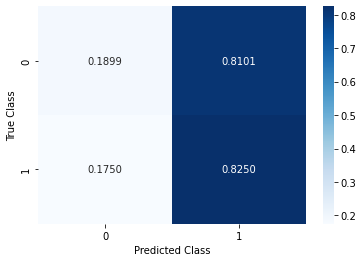

In [17]:
import seaborn as sns

cm = np.sum(best_cm, axis=0)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt=".4f", cmap='Blues')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()